In [1]:
suppressMessages(library(dplyr))
library(tidyr)
suppressMessages(library(reshape2))
suppressWarnings(suppressMessages(library(RSQLite)))
library(stringr)
suppressMessages(library(vegan))

In [2]:
getwd()

[1] "/mnt/research/ShadeLab/GLBRC"

### Read in OTU table

In [2]:
otu <- read.table("tables/GeneCounts.tsv",sep="\t", header=TRUE, stringsAsFactors = FALSE, row.names=1, quote="\"")
otu[is.na(otu)] <- 0

# DB Prep

<a href="#cleaning">Next</a>

In [3]:
#Preping the environmental metadata
glbrc <- dbConnect(SQLite(), dbname="ShadeLabCode/R/InputFiles/GLBRC_bioenergy_db.db" )
# dbListTables(glbrc)  #Content of the DB

#Content of selected tables in the DB
# dbListFields(glbrc, 'plant')
# dbListFields(glbrc, 'sequencing')
# dbListFields(glbrc, 'soil')
# dbListFields(glbrc, 'nucleic_acids')

# #get tables into R
glbrc_NA <-suppressWarnings(dbGetQuery(glbrc, "select * from nucleic_acids"))
glbrc_soil <- suppressWarnings(dbGetQuery(glbrc, 'select * from soil'))
glbrc_plant <- suppressWarnings(dbGetQuery(glbrc, 'select * from plant'))
glbrc_plot <- suppressWarnings(dbGetQuery(glbrc, 'select * from plot'))
glbrc_sampling <- suppressWarnings(dbGetQuery(glbrc, 'select * from sampling'))
glbrc_sequncing <- suppressWarnings(dbGetQuery(glbrc, 'select * from sequencing'))
glbrc_sequncing <- suppressWarnings(glbrc_sequncing %>% 
  mutate(nucleic_acid_name = str_trim(glbrc_sequncing$nucleic_acid_name, side = "both")))

#joining tables to create complete map file
metadata <- full_join(glbrc_plot, glbrc_sampling, by='plotID')
metadata <- full_join(metadata, glbrc_soil, by='sampleID')
metadata <- full_join(metadata, glbrc_plant, by='sampleID')
metadata <- full_join(metadata, glbrc_NA, by='sampleID')
metadata <- full_join(metadata, glbrc_sequncing, by='nucleic_acid_name')

map <- metadata
map_mg<- subset(map, map$sequencing_type== "Illumina Hiseq Metagenome Sequencing")
# map_16 <- subset(map, map$primers == 'EMP V4')
# map_16$help_name = as.character(lapply(strsplit(as.character(map_16$nucleic_acid_name), split="D"), "[", 1))

map_full = map

#creating numeric time column
map_full$sampling_date <- paste0(map_full$month,'-', map_full$day,'-',map_full$year) 
map_full$sampling_date <- as.POSIXct(map_full$sampling_date, format='%m-%d-%Y')
time <- as.POSIXct(map_full$sampling_date, format='%m-%d-%Y')
time_numeric <- as.numeric(time)
map_time <- cbind(map_full, time_numeric)

#adding weather data
weather <- read.csv('ShadeLabCode/R/InputFiles/kbs_weather_09212017.csv', encoding = 'UTF-8', na.strings= c("NA", " ", ""))
weather$sampling_date <- as.POSIXct(weather$date, format='%d.%m.%y')
sub_weather <- weather[weather$sampling_date %in% map_time$sampling_date,] #subsetting weather file for sample dates

#merging dataframes - map file and weather
map_complete <- suppressMessages(full_join(map_time, weather))
map_filtered = map_complete %>% filter(sequence_name %in% colnames(otu))
dim(map_filtered)

cols = colnames(otu)
otu = otu[,order(cols)]
cols = colnames(otu)
mapcols = map_filtered$sequence_name
map_filtered = map_filtered[order(mapcols),]
mapcols = map_filtered$sequence_name

sum(cols == mapcols)

[1] 136  94

[1] 136

<h2><strike><a id="cleaning">Data cleaning and filtering</a></strike></h2>

<a href="#rarify">Next</a>

In [52]:
# # #Subset to 16S Samples
# # map_16S <- subset(map_complete, map_complete$primers=="EMP V4")
# # # Get the name of the samples we have data for
# # # Remove any duplicates that we don't want to use
# # map_small <- map_16S[map_16S$exclude_from_analysis=="N",]

# #map_small_v1 <- subset(map_16S_small, map_16S_small$removing == 'remove') 
# #map_small <- map_16S_small[!(rownames(map_16S_small) %in% c(33,108, 185,259,37,418,467,487,571)),]

# samples <- colnames(otu)
# # put taxonomy into its own variable
# # taxonomy <- read.csv('ShadeLabCode/R/InputFiles/taxonomy_combined_merged_trimmed_otus.csv', header = T, row.names = 1, na.strings= c("NA", " ", ""))
# # subset the map to include only those samples we have sequence data
# map_small <- map_small[map_small$sequence_name %in% samples,]


# # Remove rows that have N/A for the sequence name
# map_small<- map_small[complete.cases(map_small$sequence_name),]

# # # Subset the samples to those we want to analyse (IE remove the duplicates)
# # samples <- samples[samples %in% map_small$sequence_name]
# # #Subset the OTU table to only the samples we want to analyze(IE remove the duplicates)
# # otu_sub <- otu[,colnames(otu) %in% samples]
# # # Order the samples
# # otu_sub <- otu_sub[,order(colnames(otu_sub))]
# # # Order the samples of the map the same way
# # map_small <- map_small[order(map_small$sequence_name),]
# # Check to make sure they all match with each other
# # colnames(otu_sub) == map_small$sequence_name

# # # Map file that has duplicates of samples removed
# # map_16S <- map_small
# # # OTU table that removes duplicates of single samples
# # otu <- otu_sub
# # otu_CM <- otu
# #removing Eukaryota from the OTU table
# # tax_short <- taxonomy[!grepl("Mitochondria", taxonomy$Family),]
# # tax_short <- tax_short[!grepl("Chloroplast", tax_short$Class),]

# # otu <- otu[rownames(otu) %in% rownames(tax_short),]

# # taxonomy_full <- taxonomy
# # taxonomy <- taxonomy[rowSums(otu_sub)>0,]
# # otu <- otu[rowSums(otu)>0,]
# # otu_soil <- otu[,map_16S$source=="soil"]

# # tax_filtered <- tax_short%>%
# #   mutate(otu = rownames(tax_short)) %>%
# #   filter(!is.na(Phylum))

# # silva_bact_only <- read.csv('ShadeLabCode/R/InputFiles/silva_bacteria_only_glbrc.csv', header=T)

# # keep_otus <- silva_bact_only %>%
# #   filter(lca_tax_slv != 'Unclassified;') %>%
# #   separate(lca_tax_slv, into=c("Kingdom", "Phylum", "Class", 
# #                                "Order", "Family", "Genus", "Species"), sep=";", remove=F) %>%
# #   mutate(taxonomy = lca_tax_slv) %>%
# #   filter(Kingdom!= 'Eukaryota') %>%
# #   select(-lca_tax_slv) %>%
#   bind_rows(tax_filtered) %>%
# #   select(-taxonomy)

# # otu_filtered <- otu[rownames(otu) %in% keep_otus$otu,]
# otu_filtered = otu

<h2><strike><a id="rarify">Rarify and Plot</a></strike></h2>
<a href="#alpha">Next</a>

In [6]:
# set.seed(13)
# #otu_rare <- t(rrarefy(t(otu), min(colSums(otu))))
# otu_rare<- suppressWarnings(t(rrarefy(t(otu_filtered), 1000)))
# otu_soil_rare <- t(rrarefy(t(otu_soil), min(colSums(otu_soil))))
# otu_141 <- suppressWarnings(t(rrarefy(t(otu_filtered), min(colSums(otu_filtered)))))

# otu.141 <- otu_141[,colSums(otu_141)>140]
# otu_rare <- otu_rare[,colSums(otu_rare)>999]
# map_16S <- map_16S[map_16S$sequence_name%in%colnames(otu_rare),]
# map_16S.141 <- map_16S[map_16S$sample_name%in%colnames(otu_141)]

# curve_colors <- rep("darkgreen", ncol(otu))
# curve_colors[map_small$source=="phyllosphere"&map_small$plant=="switchgrass"] <- "darkolivegreen3"
# curve_colors[map_small$source=="soil"&map_small$plant=="switchgrass"] <- "burlywood"
# curve_colors[map_small$source=="soil"&map_small$plant=="miscanthus"] <- "burlywood4"

# curve_colors_rare <- rep("darkgreen", ncol(otu))
# curve_colors_rare[map_16S$source=="phyllosphere"&map_16S$plant=="switchgrass"] <- "darkolivegreen3"
# curve_colors_rare[map_16S$source=="soil"&map_16S$plant=="switchgrass"] <- "burlywood"
# curve_colors_rare[map_16S$source=="soil"&map_16S$plant=="miscanthus"] <- "burlywood4"

# # rarecurve(t(otu), step=1000, sample=max(colSums(otu)), label=FALSE, col = curve_colors)
# # rarecurve(t(otu), step=50, sample=10000, label=FALSE, col = curve_colors, xlim=c(0,1000))
# # rarecurve(t(otu_rare), step=50, label=FALSE, col= curve_colors_rare)

# #rarecurve(t(otu_rare), step=20, sample = min(colSums(otu_rare)), label = FALSE)
# #otu_rare <- otu_rare[,colSums(otu_rare)>999]

# # ### Multiplot code taken from http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
# multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
#   library(grid)
  
#   # Make a list from the ... arguments and plotlist
#   plots <- c(list(...), plotlist)
#   numPlots = length(plots)
  
#   # If layout is NULL, then use 'cols' to determine layout
#   if (is.null(layout)) {
#     # Make the panel
#     # ncol: Number of columns of plots
#     # nrow: Number of rows needed, calculated from # of cols
#     layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
#                      ncol = cols, nrow = ceiling(numPlots/cols))
#   }
  
#   if (numPlots==1) {
#     print(plots[[1]])
#   } else {
#     # Set up the page
#     grid.newpage()
#     pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    
#     # Make each plot, in the correct location
#     for (i in 1:numPlots) {
#       # Get the i,j matrix positions of the regions that contain this subplot
#       matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
#       print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
#                                       layout.pos.col = matchidx$col))
#     }
#   }
# }
# ### End Common
# saveRDS(map_16S,"pickles/map_16S.rds") 
# saveRDS(map_16S.141,"pickles/map_16S.141.rds")
# saveRDS(otu.141,"pickles/otu.141.rds")
# saveRDS(otu_141,"pickles/otu_141.rds")
# saveRDS(otu_rare,"pickles/otu_rare.rds")
# saveRDS(otu_soil_rare,"pickles/otu_soil_rare.rds")
# otu_rare = readRDS('pickles/otu_rare.rds')

# Jackson Analysis

<h2><a id="alpha">Alpha Diversity</a></h2>
<a href="#accumlation">Next</a>

In [8]:
library(ggplot2)
library(scales)
otu_rare = otu
map_16S = map_filtered
otu_rare.PA <- 1*(otu_rare>0)
s <- specnumber(otu_rare,MARGIN=2)
h <- diversity(t(otu_rare), index = "shannon")
pielou=h/log(s)
map_16S$sampling_date <- gsub(pattern = " EDT", replacement = "", map_16S$sampling_date)
map_16S$sampling_Rdate <- as.Date(map_16S$sampling_date)
otu_rare.phyllo.PA <- otu_rare.PA[,map_16S$source=="phyllosphere"]
sum(rowSums(otu_rare.phyllo.PA)>0)

[1] 6159

In [6]:
### Settin up Contextual Data Maps
map.2017 <- map_16S[map_16S$year=="2017",]
map.2016 <- map_16S[map_16S$year=="2016",]

map.plant <- map_16S[map_16S$source=="phyllosphere",]
map.plant.2016 <- map.plant[map.plant$year==2016,]
map.plant.2017 <- map.plant[map.plant$year==2017,]
map.plant.switch <- map.plant.2016[map.plant.2016$plant=="switchgrass",] 
map.plant.misc <- map.plant.2016[map.plant.2016$plant=="miscanthus",]

map.div <- map_16S
map.div$Richness <- s
map.div$Shannon <- h
map.div$Pielou <- pielou 
map.div.plant <- map.div[map.div$source=="phyllosphere",]
map.div.mis <- map.div.plant[map.div.plant$plant=="miscanthus",]
map.div.swg <- map.div.plant[map.div.plant$plant=="switchgrass",]

map.alpha <- melt(map.div, id.vars=c("sequence_name","treatment", "source", "plant", "time_numeric", "sampling_Rdate","year"), measure.vars=c("Richness", "Shannon", "Pielou"))
map.alpha.plant <- map.alpha[map.alpha$source=="phyllosphere",]
map.alpha.plant.2016 <- map.alpha[map.alpha$source=="phyllosphere"&map.alpha$year==2016,]
map.alpha.plant.2017 <- map.alpha[map.alpha$source=="phyllosphere"&map.alpha$year==2017,]

misc.map.2016 <- map.plant.2016[map.plant.2016$plant=="miscanthus",]
switch.map <- map.plant[map.plant$plant=="switchgrass",]
switch.map.2016 <- map.plant[map.plant$plant=="switchgrass"&map.plant$year==2016,]
switch.map.2017 <- map.plant[map.plant$plant=="switchgrass"&map.plant$year==2017,]

cor.test(map.div.swg$time_numeric, map.div.swg$Richness)
cor.test(map.div.swg$time_numeric, map.div.swg$Shannon)
cor.test(map.div.swg$time_numeric, map.div.swg$Pielou)
cor.test(map.div.mis$time_numeric, map.div.mis$Richness)
cor.test(map.div.mis$time_numeric, map.div.mis$Shannon)
cor.test(map.div.mis$time_numeric, map.div.mis$Pielou)


	Pearson's product-moment correlation

data:  map.div.swg$time_numeric and map.div.swg$Richness
t = 22.82, df = 62, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9112429 0.9665307
sample estimates:
      cor 
0.9453103 



	Pearson's product-moment correlation

data:  map.div.swg$time_numeric and map.div.swg$Shannon
t = 22.983, df = 62, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9123741 0.9669694
sample estimates:
      cor 
0.9460196 



	Pearson's product-moment correlation

data:  map.div.swg$time_numeric and map.div.swg$Pielou
t = 20.011, df = 62, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8878231 0.9573740
sample estimates:
     cor 
0.930553 



	Pearson's product-moment correlation

data:  map.div.mis$time_numeric and map.div.mis$Richness
t = 23.549, df = 70, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9090815 0.9636092
sample estimates:
      cor 
0.9422971 



	Pearson's product-moment correlation

data:  map.div.mis$time_numeric and map.div.mis$Shannon
t = 21.208, df = 70, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8904623 0.9558987
sample estimates:
      cor 
0.9302314 



	Pearson's product-moment correlation

data:  map.div.mis$time_numeric and map.div.mis$Pielou
t = 16.709, df = 70, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8355857 0.9326365
sample estimates:
      cor 
0.8941631 


<h2><a id ='accumlation'>Look at species accumulation</a></h2>
<a href="#gene_accumlation">Next</a>

In [7]:
plant_rare_otu <- otu_rare[,map_16S$source=="phyllosphere"]
plant_rare_otu.2016 <- otu_rare[,map_16S$source=="phyllosphere"&map_16S$year==2016]
misc_rare_otu.2016 <- plant_rare_otu.2016[,map.plant.2016$plant=="miscanthus"]
switch_rare_otu <- plant_rare_otu[,map.plant$plant=="switchgrass"]
switch.rare.otu.2016 <- plant_rare_otu[,map.plant$plant=="switchgrass"&map.plant$year==2016]
misc_unique_times <- unique(misc.map.2016$time_numeric)[order(unique(misc.map.2016$time_numeric))]

### Phyllosphere switchgrass unique times
switch_unique_times <- unique(switch.map$time_numeric)[order(unique(switch.map$time_numeric))]
switch_unique_times.2016 <- unique(switch.map.2016$time_numeric)[order(unique(switch.map.2016$time_numeric))]

misc_accumulation <- rep(1, length(misc_unique_times))
z <- NULL
for( i in 1:length(unique(misc.map.2016$time_numeric))){
  x <- misc_rare_otu.2016[,misc.map.2016$time_numeric==misc_unique_times[i]]
  z <- c(z, row.names(misc_rare_otu.2016[rowSums(x)!=0,]))
  misc_accumulation[i] <- length(unique(z))
}

switch_accumulation.2016 <- rep(1, length(switch_unique_times.2016))
z <- NULL
for( i in 1:length(unique(switch.map.2016$time_numeric))){
  x <- switch.rare.otu.2016[,switch.map.2016$time_numeric==switch_unique_times.2016[i]]
  z <- c(z, row.names(x[rowSums(x)!=0,]))
  switch_accumulation.2016[i] <- length(unique(z))
}

switch_accumulation <- rep(1, length(switch_unique_times))
z <- NULL
for( i in 1:length(unique(switch.map$time_numeric))){
  x <- switch_rare_otu[,switch.map$time_numeric==switch_unique_times[i]]
  z <- c(z, row.names(x[rowSums(x)!=0,]))
  switch_accumulation[i] <- length(unique(z))
}

Spec_accum.2016 <- NULL
Spec_accum.2016$Species_Accumulation <- c(misc_accumulation, switch_accumulation.2016)
Spec_accum.2016$Date <- c(unique(misc.map.2016$sampling_Rdate)[order(unique(misc.map.2016$sampling_Rdate))], unique(switch.map.2016$sampling_Rdate)[order(unique(switch.map.2016$sampling_Rdate))])
Spec_accum.2016 <- as.data.frame(Spec_accum.2016)
Spec_accum.2016$Plant <- c(rep("Miscanthus", 9), rep("Switchgrass", 8))
Spec_accum_total <- NULL
Spec_accum_total$Species_Accumulation <- c(misc_accumulation, switch_accumulation.2016 )#, switch_accumulation.2017)
Spec_accum_total$Date <- c(unique(misc.map.2016$sampling_Rdate)[order(unique(misc.map.2016$sampling_Rdate))], unique(switch.map.2016$sampling_Rdate)[order(unique(switch.map.2016$sampling_Rdate))] ) #, NewDates_Switch2017)
Spec_accum_total <- as.data.frame(Spec_accum_total)
Spec_accum_total$Plant <- c(rep("Miscanthus", length(misc_accumulation)), rep("Switchgrass", length(switch_accumulation.2016))) #, rep("Switchgrass", length(switch_accumulation.2017)))

<h2><a id="richness">Richness statistical test</a></h2>

In [8]:
# Code of Figure 2, Phyllosphere richness and accumulation through the season
switch.Richness.2016 <- map.alpha.plant.2016[map.alpha.plant.2016$plant=="switchgrass"&map.alpha.plant.2016$variable=="Richness",]
fit_model <- aov(value~factor(sampling_Rdate),switch.Richness.2016)
summary(fit_model)
TukeyHSD(fit_model)

misc.Richness <- map.alpha.plant[map.alpha.plant$plant=="miscanthus"&map.alpha.plant$variable=="Richness",]
fit_model <- aov(value~factor(sampling_Rdate),misc.Richness)
summary(fit_model)
TukeyHSD(fit_model)

                       Df    Sum Sq  Mean Sq F value Pr(>F)    
factor(sampling_Rdate)  7 235336557 33619508   302.2 <2e-16 ***
Residuals              56   6230973   111267                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ factor(sampling_Rdate), data = switch.Richness.2016)

$`factor(sampling_Rdate)`
                          diff        lwr       upr     p adj
2016-05-31-2016-05-09  -46.125 -571.20763  478.9576 0.9999930
2016-06-20-2016-05-09  457.875  -67.20763  982.9576 0.1306186
2016-07-12-2016-05-09  613.625   88.54237 1138.7076 0.0115527
2016-08-01-2016-05-09 2303.375 1778.29237 2828.4576 0.0000000
2016-08-22-2016-05-09 3719.250 3194.16737 4244.3326 0.0000000
2016-09-12-2016-05-09 4580.500 4055.41737 5105.5826 0.0000000
2016-10-03-2016-05-09 4690.000 4164.91737 5215.0826 0.0000000
2016-06-20-2016-05-31  504.000  -21.08263 1029.0826 0.0686457
2016-07-12-2016-05-31  659.750  134.66737 1184.8326 0.0050070
2016-08-01-2016-05-31 2349.500 1824.41737 2874.5826 0.0000000
2016-08-22-2016-05-31 3765.375 3240.29237 4290.4576 0.0000000
2016-09-12-2016-05-31 4626.625 4101.54237 5151.7076 0.0000000
2016-10-03-

                       Df    Sum Sq  Mean Sq F value Pr(>F)    
factor(sampling_Rdate)  8 190707966 23838496   114.7 <2e-16 ***
Residuals              63  13088818   207759                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ factor(sampling_Rdate), data = misc.Richness)

$`factor(sampling_Rdate)`
                          diff          lwr       upr     p adj
2016-05-31-2016-05-09  194.250  -537.779122  926.2791 0.9945826
2016-06-20-2016-05-09 1294.500   562.470878 2026.5291 0.0000126
2016-07-12-2016-05-09  932.750   200.720878 1664.7791 0.0037048
2016-08-01-2016-05-09 2128.125  1396.095878 2860.1541 0.0000000
2016-08-22-2016-05-09 3316.500  2584.470878 4048.5291 0.0000000
2016-09-12-2016-05-09 3792.250  3060.220878 4524.2791 0.0000000
2016-10-03-2016-05-09 3841.875  3109.845878 4573.9041 0.0000000
2016-11-07-2016-05-09 4666.125  3934.095878 5398.1541 0.0000000
2016-06-20-2016-05-31 1100.250   368.220878 1832.2791 0.0002996
2016-07-12-2016-05-31  738.500     6.470878 1470.5291 0.0463978
2016-08-01-2016-05-31 1933.875  1201.845878 2665.9041 0.0000000
2016-08-22-2016-05-31 3122.250  2390.220878 3854.2791 0.

<h2><a id="gene_accumlation">2016 - Gene Accumlation</a></h2>

<a href="#welch">Next</a>

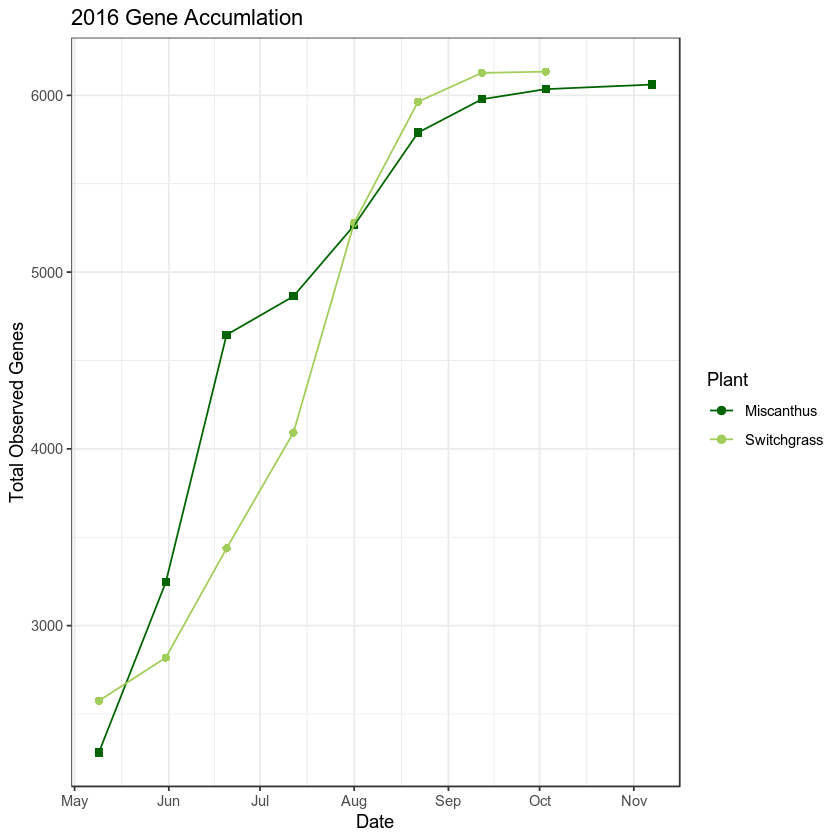

In [9]:
# switch.Richness.2017 <- map.alpha.plant.2017[map.alpha.plant.2017$plant=="switchgrass"&map.alpha.plant.2017$variable=="Richness",]
Richness.df <- rbind(switch.Richness.2016, misc.Richness) #switch.Richness.2017, 
Richness.df$Factor <- factor(c(rep("Switchgrass 2016", nrow(switch.Richness.2016)),  rep("Miscanthus 2016", nrow(misc.Richness))), levels = c("Miscanthus 2016", "Switchgrass 2016")) #rep("Switchgrass 2017", nrow(switch.Richness.2017)),
# Richness.df$FakeDate <- as.Date(gsub(x=Richness.df$sampling_Rdate, replacement = "2016" )) #rep("Switchgrass 2017", nrow(switch.Richness.2017)),

### Spec Accumulation Curves
Spec_accum_total$Year <- c(rep("2016",length(misc_accumulation)), rep("2016",length(switch_accumulation.2016))) #, rep("2017",length(switch_accumulation.2017)
# Spec_accum_total
Spec_accum_total$PlantYear <- paste(Spec_accum_total$Plant, Spec_accum_total$Year)

Fig1B <- ggplot(Spec_accum_total, aes(x=Date, y=Species_Accumulation)) + 
  geom_point(aes(color=Plant, shape=PlantYear), size=2) +
  geom_line(aes(color=Plant, linetype=Year))+
  scale_shape_manual(values=c(15,16,1))+
  scale_linetype_manual(values = c(1,2))+
  theme_bw()+
  labs(y="Total Observed Genes",title="2016 Gene Accumlation") + 
  scale_color_manual(values=c("darkgreen","darkolivegreen3"))  + 
  scale_x_date(date_breaks = "1 month", labels=date_format("%b"))+
  guides(linetype=FALSE,shape=FALSE)
ggsave("ShadeLabCode/R/Figures/Figure1B_GenesAccumulation.eps", Fig1B, device = "eps", width=6, height=4, units = "in")
Fig1B

<h2><a id="welch">Welch Test</a></h2>

<a href="#beta">Next</a>

In [10]:
# Plot Miscanthus Evenness Through Season
switch.Pielou.2016 <- map.alpha.plant.2016[map.alpha.plant.2016$plant=="switchgrass"&map.alpha.plant.2016$variable=="Pielou",]
# switch.Pielou.2017 <- map.alpha.plant.2017[map.alpha.plant.2017$plant=="switchgrass"&map.alpha.plant.2017$variable=="Pielou",]
misc.Pielou.2016 <- map.alpha.plant.2016[map.alpha.plant.2016$plant=="miscanthus"&map.alpha.plant.2016$variable=="Pielou",]
t.test(map.alpha.plant.2016[map.alpha.plant.2016$variable=="Richness"&map.alpha.plant.2016$treatment=="standard fertilization",]$value, map.alpha.plant.2016[map.alpha.plant.2016$variable=="Richness"&map.alpha.plant.2016$treatment=="nitrogen free",]$value)


	Welch Two Sample t-test

data:  map.alpha.plant.2016[map.alpha.plant.2016$variable == "Richness" &  and map.alpha.plant.2016[map.alpha.plant.2016$variable == "Richness" &     map.alpha.plant.2016$treatment == "standard fertilization",  and     map.alpha.plant.2016$treatment == "nitrogen free", ]$value    ]$value and map.alpha.plant.2016[map.alpha.plant.2016$variable == "Richness" & 
t = 0.12527, df = 133.81, p-value = 0.9005
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -579.5862  657.9685
sample estimates:
mean of x mean of y 
 3312.574  3273.382 


<h1><a id="beta">Beta Diversity</a></h1>
<a href="#pcoa">Next</a>
<h2><a id="">Time F-Stat</a></h2>

In [11]:
dist.otu <- vegdist(t(otu_rare), method="bray")
adonis(dist.otu~map_16S$time_numeric)
map.switch <- map_16S[map_16S$plant=="switchgrass",]
map.misc <- map_16S[map_16S$plant=="miscanthus",]


Call:
adonis(formula = dist.otu ~ map_16S$time_numeric) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
map_16S$time_numeric   1    11.749 11.7490  98.028 0.42248  0.001 ***
Residuals            134    16.060  0.1199         0.57752           
Total                135    27.809                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

<h2><a id="">Treatment F-Stat</a></h2>

In [12]:
dist.otu <- vegdist(t(otu_rare), method="bray")
adonis(dist.otu~map_16S$treatment)


Call:
adonis(formula = dist.otu ~ map_16S$treatment) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                   Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)
map_16S$treatment   1    0.0764 0.076445 0.36937 0.00275   0.83
Residuals         134   27.7329 0.206962         0.99725       
Total             135   27.8093                  1.00000       

<h2><a id="">Plant F-Stat</a></h2>

In [13]:
dist.otu <- vegdist(t(otu_rare), method="bray")
adonis(dist.otu~map_16S$plant)


Call:
adonis(formula = dist.otu ~ map_16S$plant) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

               Df SumsOfSqs MeanSqs F.Model     R2 Pr(>F)    
map_16S$plant   1    3.1479 3.14789  17.104 0.1132  0.001 ***
Residuals     134   24.6614 0.18404         0.8868           
Total         135   27.8093                 1.0000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

<h2><a id="pcoa">Collapsed plant PCoA Calculations</a></h2>
<a href="#pcoa_graph">Next</a>

In [14]:
pcoa.plant <- cmdscale(dist.otu, eig=TRUE)
pcoa.plant

G5R1_MAIN_01AUG2016_LD1,-0.134104812,0.197334833
G5R1_MAIN_03OCT2016_LD1,0.576871494,-0.295402175
G5R1_MAIN_09MAY2016_LD1,-0.316422933,-0.327976457
G5R1_MAIN_12JUL2016_LD1,-0.259073017,-0.011205277
G5R1_MAIN_12SEP2016_LD1,0.523368528,-0.187721354
G5R1_MAIN_20JUN2016_LD1,-0.271715967,-0.046852656
G5R1_MAIN_22AUG2016_LD1,0.331701084,0.067321193
G5R1_MAIN_31MAY2016_LD1,-0.304151486,-0.074847513
G5R1_NF_01AUG2016_LD1,-0.004767212,0.254644532
G5R1_NF_03OCT2016_LD1,0.564863700,-0.247454659
G5R1_NF_09MAY2016_LD1,-0.345571643,-0.183492724


In [15]:
### Start by getting the dates for plant smaples
dates <- unique(map_16S$sampling_date)[order(unique(map_16S$sampling_date))]
dates.switch <- unique(map.switch$sampling_date)[order(unique(map.switch$sampling_date))]
dates.misc <- unique(map.misc$sampling_date)[order(unique(map.misc$sampling_date))]

In [16]:
plant.dates <- unique(map.plant$sampling_date)[order(unique(map.plant$sampling_date))]
sg.dates <- unique(map.plant.switch$sampling_date)[order(unique(map.plant.switch$sampling_date))]
ms.dates <- unique(map.plant.misc$sampling_date)[order(unique(map.plant.misc$sampling_date))]

### Set up the points from the "entire" plant PCoA
plant.points <- pcoa.plant$points
sg.points <- plant.points[map_16S$plant=="switchgrass",]
ms.points <- plant.points[map_16S$plant=="miscanthus",]

### determine the average location of each crop on the PCoA at each timepoint
sg.points.collapsed <- NULL
sg.samples.per.date <- NULL
for (i in 1:length(sg.dates)){
  x <- plant.points[map.plant$sampling_date==sg.dates[i]&map.plant$plant=="switchgrass",]
  sg.samples.per.date <- c(sg.samples.per.date, nrow(x))
  sg.points.collapsed <- rbind(sg.points.collapsed, c(colSums(x), sd(x[,1]), sd(x[,2])))
}
sg.points.collapsed <- as.data.frame(sg.points.collapsed)
colnames(sg.points.collapsed) <- c("Axis1", "Axis2", "sd_axis1", "sd_axis2")
sg.points.collapsed$sampling_date <- sg.dates
sg.points.collapsed[,1:2] <- sg.points.collapsed[,1:2]/sg.samples.per.date
sg.points.collapsed

Axis1,Axis2,sd_axis1,sd_axis2,sampling_date
-0.3236268,-0.28211006,0.01319374,0.06182365,2016-05-09
-0.3130726,-0.21554153,0.01456328,0.09338835,2016-05-31
-0.2836142,-0.05169342,0.01774390,0.07105727,2016-06-20
-0.1980071,0.11700001,0.05431781,0.08660633,2016-07-12
-0.1488906,0.07485735,0.06408457,0.15837157,2016-08-01
0.2571382,0.10459778,0.17009612,0.11089125,2016-08-22
0.4759404,-0.09491128,0.05519330,0.08250644,2016-09-12
0.5567304,-0.26415614,0.03836987,0.04849152,2016-10-03


In [17]:
ms.points.collapsed <- NULL
ms.samples.per.date <- NULL
for(i in 1:length(ms.dates)){
  x <- ms.points[map.plant.misc$sampling_date==ms.dates[i],]
  ms.samples.per.date <- c(ms.samples.per.date, nrow(x))
  ms.points.collapsed <- rbind(ms.points.collapsed, c(colSums(matrix(x, ncol=2)), sd(matrix(x,ncol=2)[,1]), sd(matrix(x, ncol=2)[,2])))
}

ms.points.collapsed <- as.data.frame(ms.points.collapsed)
colnames(ms.points.collapsed) <- c("Axis1", "Axis2", "sd_axis1", "sd_axis2")
ms.points.collapsed$sampling_date <- ms.dates
ms.points.collapsed[,1:2] <- ms.points.collapsed[,1:2]/ms.samples.per.date

ms.points.collapsed

Axis1,Axis2,sd_axis1,sd_axis2,sampling_date
-0.29021535,-0.1095918,0.03047670,0.11688511,2016-05-09
-0.30102561,-0.2000059,0.02169606,0.06023511,2016-05-31
-0.25295863,-0.0254240,0.03373607,0.16266293,2016-06-20
-0.17860172,0.1935114,0.04821435,0.12643756,2016-07-12
-0.06745861,0.2656846,0.08322767,0.07152266,2016-08-01
0.05176034,0.2304028,0.03460866,0.08028116,2016-08-22
0.17497291,0.2397782,0.08211192,0.06231240,2016-09-12
0.29218749,0.2413207,0.13367007,0.10470612,2016-10-03
0.54874154,-0.2237187,0.04313334,0.04051219,2016-11-07


In [18]:
plant.points.collapsed <- rbind(sg.points.collapsed, ms.points.collapsed)
# plant.points.collapsed <- left_join(plant.points.collapsed, Date_to_Week, by="sampling_date")
plant.points.collapsed$plant <- c(rep("Switchgrass", length(sg.dates)), rep("Miscanthus", length(ms.dates)))
# plant.points.collapsed$Week <- factor(x = plant.points.collapsed$Week, levels=c(1,2,3,4,5,6,7,8,9,10))
# plant.points.collapsed$WeekNumeric <- as.numeric(plant.points.collapsed$Week)
# plant.points.collapsed$Year <- c(rep(2016,6), rep(2017,7), rep(2016,9))
# plant.points.collapsed$Year <- factor(plant.points.collapsed$Year, levels = c(2016,2017))
plant.points.collapsed$plant <- factor(plant.points.collapsed$plant, levels = c("Switchgrass", "Miscanthus"))
plant.points.collapsed <- plant.points.collapsed[order(plant.points.collapsed$sampling_date),]

### Set up the weather maps for Weather Environmental fits
# switch.weather <- map.plant.switch[,c("precipitation", "Air_temp_mean", "air_temp_max", "Air_Temp_Min", "Air_Pressure", "RH", "AH", "Wind_Speed_Mean", "Solar_Radiation", "PAR", "soil_temp_5_cm_bare_avg", "sampling_date", "time_numeric")]
# switch.weather <- unique(switch.weather)
# switch.weather.2017 <- map.plant.2017[,c("precipitation", "Air_temp_mean", "air_temp_max", "Air_Temp_Min", "Air_Pressure", "RH", "AH", "Wind_Speed_Mean", "Solar_Radiation", "PAR", "soil_temp_5_cm_bare_avg", "sampling_date", "time_numeric")]
# switch.weather.2017 <- unique(switch.weather.2017)
# misc.weather <- map.plant.misc[,c("precipitation", "Air_temp_mean", "air_temp_max", "Air_Temp_Min", "Air_Pressure", "RH", "AH", "Wind_Speed_Mean", "Solar_Radiation", "PAR", "soil_temp_5_cm_bare_avg", "sampling_date", "time_numeric")]
# misc.weather <- unique(misc.weather)
# scale_arrow <- function(arrows, data, at = c(0, 0), fill = 0.75) {
#   u <- c(range(data[,1], range(data[,2])))
#   u <- u - rep(at, each = 2)
#   r <- c(range(arrows[, 1], na.rm = TRUE), range(arrows[, 2], na.rm = TRUE))
#   rev <- sign(diff(u))[-2]
#   if (rev[1] < 0) {
#     u[1:2] <- u[2:1]
#   }
#   if (rev[2] < 0) {
#     u[3:4] <- u[4:3]
#   }
#   u <- u/r
#   u <- u[is.finite(u) & u > 0]
#   invisible(fill * min(u))
# }

# arrow_scaling <- scale_arrow(data = scores(pcoa.plant, display = "sites"), arrows = scores(envfit.phyllo.sc, display = "vectors"))
# arrow_scaling <- scale_arrow(data = scores(pcoa.plant, display = "sites"), arrows = rbind(scores(envfit.phyllo.sc, display="vectors"), scores(envfit.phyllo.lc, display="vectors")))
# ### Set up EnvFit for ggplot (remembering to use vegan:::ordiArrowMul to adjust arrow sizes)
# phyllo.weather <- rbind(switch.weather, switch.weather.2017, misc.weather)
# phyllo.weather <- phyllo.weather[order(phyllo.weather$sampling_date),]
# phyllo.weather$sampling_date == plant.points.collapsed$sampling_date
# phyllo.weather$Week <- plant.points.collapsed$WeekNumeric
# envfit.phyllo.weather <- envfit(plant.points.collapsed[,1:2], phyllo.weather[,c(1:11,14)])
# envfit.phyllo.weather.df<-as.data.frame(scores(envfit.phyllo.weather, display = "vectors"))
# colnames(envfit.phyllo.weather.df) <- c("Dim1", "Dim2")
# phyllo.leaf.chemistry <- map.plant[,c("LDMC_mg_per_g", "nitrogen_percent", "carbon_percent", "carbon_per_nitrogen", "height_mean_cm")]
# envfit.phyllo.lc <- envfit(pcoa.plant$points, phyllo.leaf.chemistry)
# envfit.phyllo.lc.df<-as.data.frame(scores(envfit.phyllo.lc, display = "vectors"))
# phylloi.soil.chemsitry <- map.plant[,c("pH", "P_ppm", "K_ppm", "Ca_ppm", "Mg_ppm", "organic_matter", "NO3N_ppm", "NH4_ppm", "soil_moisture_percent", "soil_temp_10cm")]
# envfit.phyllo.sc <- envfit(pcoa.plant$points, phylloi.soil.chemsitry)
# envfit.phyllo.sc.df<-as.data.frame(scores(envfit.phyllo.sc, display = "vectors"))
# envfit.phyllo.total <- rbind(envfit.phyllo.weather.df, envfit.phyllo.lc.df, envfit.phyllo.sc.df)
# envfit.phyllo.total$r2 <- c(envfit.phyllo.weather$vectors$r, envfit.phyllo.lc$vectors$r, envfit.phyllo.sc$vectors$r)
# envfit.phyllo.total$pval <- c(envfit.phyllo.weather$vectors$pvals, envfit.phyllo.lc$vectors$pvals, envfit.phyllo.sc$vectors$pvals)
# arrow_scaling <- scale_arrow(arrows=envfit.phyllo.total[,1:2], data=plant.points.collapsed)
# envfit.phyllo.total$Axis1 <- envfit.phyllo.total$Dim1 * arrow_scaling
# envfit.phyllo.total$Axis2 <- envfit.phyllo.total$Dim2 * arrow_scaling
# envfit.phyllo.total$Variable <- row.names(envfit.phyllo.total)
# ### Subset to p <0.05 & Rsquared >0.4
# envfit.phyllo.sub <- subset(envfit.phyllo.total, envfit.phyllo.total$r2 >0.3999) 
# envfit.phyllo.sub <- subset (envfit.phyllo.sub , envfit.phyllo.sub$pval<0.05)
# write.table(file = "ShadeLabCode/Figures/TableS2_EnvFit.txt", x=envfit.phyllo.total[,1:4], sep="\t", quote=FALSE)
# ### Set up some of the plotting specifics
# Point_Sizes <- seq(from=2, to=6, length.out = 10)
 Ax1.plant <- pcoa.plant$eig[1]/sum(pcoa.plant$eig)
 Ax2.plant <- pcoa.plant$eig[2]/sum(pcoa.plant$eig)

<h2><a id="pcoa_graph">Plot Plant PCoA Figure</a><h5>(Fig2B)</h5></h2>
<a href="#protest">Next</a>

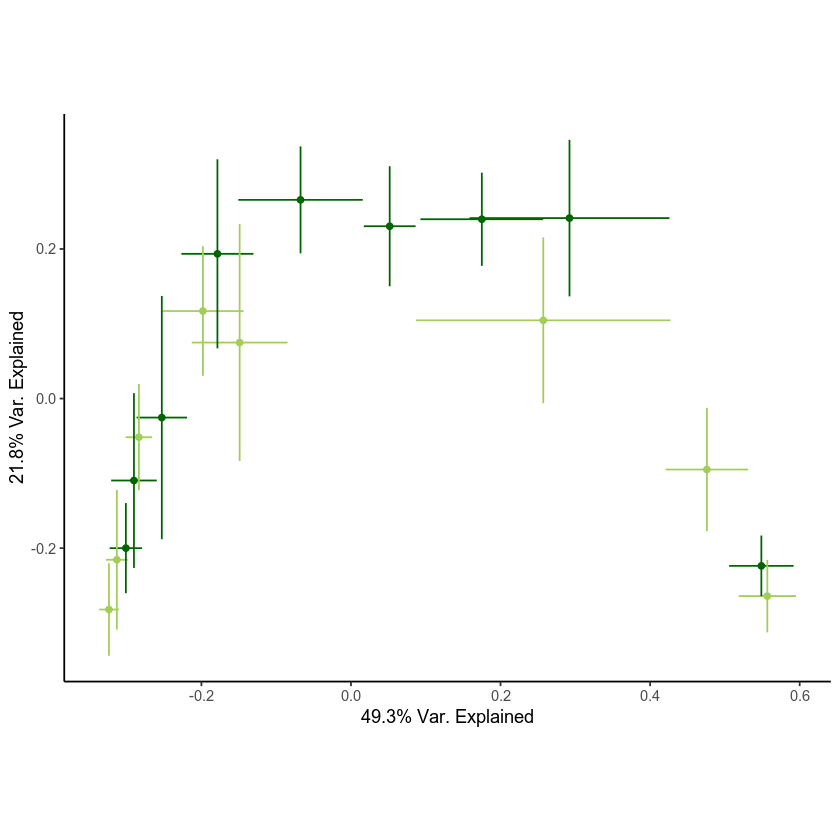

In [19]:
### Plot Plant PCoA
Fig2B <- ggplot(plant.points.collapsed, aes(x=Axis1, y=Axis2))+
  geom_point(aes( color=plant)) +
  scale_color_manual(values=c("darkolivegreen3","darkgreen"))+
  scale_shape_manual(values = c(19,1))+
  scale_size_manual(values=Point_Sizes)+
  coord_fixed()+
  geom_segment(data=plant.points.collapsed, aes(x=Axis1,xend=Axis1+sd_axis1,y=Axis2,yend=Axis2,color=plant ))+
  geom_segment(data=plant.points.collapsed, aes(x=Axis1,xend=Axis1-sd_axis1,y=Axis2,yend=Axis2,color=plant))+
  geom_segment(data=plant.points.collapsed, aes(x=Axis1,xend=Axis1,y=Axis2,yend=Axis2+sd_axis2,color=plant))+
  geom_segment(data=plant.points.collapsed, aes(x=Axis1,xend=Axis1,y=Axis2,yend=Axis2-sd_axis2,color=plant))+
  xlab(label = paste(round(Ax1.plant,digits = 3)*100, "% Var. Explained", sep = ""))+
  ylab(label= paste(round(Ax2.plant,digits = 3)*100, "% Var. Explained", sep = ""))+
  #geom_segment(data = envfit.phyllo.sub,
   #aes(x = 0, xend = Axis1, y = 0, yend = Axis2),
   #arrow = arrow(length = unit(0.25, "cm")), colour = "grey")+
 # geom_text(data=envfit.phyllo.sub, aes(label=Variable))+
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))+
  theme(legend.position = "none")
ggsave(filename = "ShadeLabCode/R/Figures/Figure2B_PhyllospherePCoAGenes.eps", Fig2B, device = "eps", height = 6, width = 6, units = "in")
Fig2B

<h2><a id="protest">ProtTest</a></h2>

In [9]:
otu_genes = otu_rare
map_genes = map_16S
otu_16S = readRDS("ShadeLabCode/pickles/otu_1000.rds")
map_16S = readRDS("ShadeLabCode/pickles/map_1000.rds")
# sum(colnames(otu_genes)%in%colnames(otu_16S))
otu_genes_overlap <- otu_genes[,colnames(otu_genes)%in%colnames(otu_16S)]
otu_16S_overlap <- otu_16S[,colnames(otu_16S)%in%colnames(otu_genes)]
# dim(otu_genes_overlap)
# dim(otu_16S_overlap)
genes.dist <- vegdist(t(otu_genes_overlap), method="bray")
otu.dist <- vegdist(t(otu_16S_overlap), method="bray")
mantel(genes.dist,otu.dist)
genes.pcoa <- cmdscale(genes.dist, eig=TRUE)
otu.pcoa <- cmdscale(otu.dist, eig=TRUE)
protest(genes.pcoa,otu.pcoa)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = genes.dist, ydis = otu.dist) 

Mantel statistic r: 0.313 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0586 0.0798 0.0985 0.1158 
Permutation: free
Number of permutations: 999



Call:
protest(X = genes.pcoa, Y = otu.pcoa) 

Procrustes Sum of Squares (m12 squared):        0.4976 
Correlation in a symmetric Procrustes rotation: 0.7088 
Significance:  0.001 

Permutation: free
Number of permutations: 999


### Jackson to update

In [ ]:
switch.otu.2016 <- otu_rare[,map_16S$source=="phyllosphere"&map_16S$plant=="switchgrass"&map_16S$year==2016&map_16S$month!=10]
switch.otu.2017 <- otu_rare[,map_16S$source=="phyllosphere"&map_16S$plant=="switchgrass"&map_16S$year==2017]
switch.map.2016.p <- map_16S[map_16S$source=="phyllosphere"&map_16S$plant=="switchgrass"&map_16S$year==2016&map_16S$month!=10,]
switch.map.2017.p <- map_16S[map_16S$source=="phyllosphere"&map_16S$plant=="switchgrass"&map_16S$year==2017,]
switch.collapsed.otu.2016 <- data.frame(Time3=rep(NA, nrow(switch.otu.2016)), Time4=rep(NA, nrow(switch.otu.2016)), Time5=rep(NA, nrow(switch.otu.2016)), Time6=rep(NA, nrow(switch.otu.2016)), Time7=rep(NA, nrow(switch.otu.2016)))
switch.collapsed.otu.2017 <- data.frame(Time3=rep(NA, nrow(switch.otu.2017)), Time4=rep(NA, nrow(switch.otu.2017)), Time5=rep(NA, nrow(switch.otu.2017)), Time6=rep(NA, nrow(switch.otu.2017)), Time7=rep(NA, nrow(switch.otu.2017)))

a <- c(4:8)

for (i in 1:5){
  temp_2016 <- switch.otu.2016[,switch.map.2016.p$Week==a[i]]
  temp_2017 <- switch.otu.2017[, switch.map.2017.p$Week==a[i]]
  switch.collapsed.otu.2016[,i] <- rowSums(temp_2016)/ncol(temp_2016)
  switch.collapsed.otu.2017[,i] <- rowSums(temp_2017)/ncol(temp_2017)
}

temp.2016 <- switch.collapsed.otu.2016
temp.2017 <- switch.collapsed.otu.2017
temp.2016$OTU <- row.names(switch.collapsed.otu.2016)
temp.2017$OTU <- row.names(switch.collapsed.otu.2017)

switch.collapsed.otu.matched <- inner_join(temp.2016, temp.2017, by="OTU")
switch.collapsed.otu.matched$OTU <- NULL
switch.collapsed.dist.2016 <- vegdist(t(switch.collapsed.otu.2016), method="bray")
switch.collapsed.dist.2017 <- vegdist(t(switch.collapsed.otu.2017), method="bray")
switch.collapsed.dist.both <- vegdist(t(switch.collapsed.otu.matched), method="bray")
switch.collapsed.pcoa.2016 <- cmdscale(switch.collapsed.dist.2016, eig=TRUE)
switch.collapsed.pcoa.2017 <- cmdscale(switch.collapsed.dist.2017, eig=TRUE)
protest(switch.collapsed.pcoa.2016, switch.collapsed.pcoa.2017)
protest(switch.collapsed.dist.2016, switch.collapsed.dist.2017)
adonis(switch.collapsed.dist.both~c(rep(2016, 7), rep(2017,7)))

switch.phyllo.map <- map_16S[map_16S$plant=="switchgrass"&map_16S$source=="phyllosphere",]
switch.dist.2017 <- vegdist(t(switch.otu.2017), method = "bray")
switch.pcoa.2017 <- cmdscale(switch.dist.2017, eig = TRUE)

plot(switch.pcoa.2017$points[,1], switch.pcoa.2017$points[,2], cex=0)
text(switch.pcoa.2017$points[,1], switch.pcoa.2017$points[,2], labels = switch.map.2017$month)

# Making matching pcoas for miscanthus and switchgrass, for use in PROTEST
otu_miscanthus_sub <- otu_rare[,map_16S$source=="phyllosphere"&map_16S$plant=="miscanthus"&map_16S$year=="2016"] 
otu_switchgrass_sub <- otu_rare[,map_16S$source=="phyllosphere"&map_16S$plant=="switchgrass"&map_16S$year=="2016"]
map_miscanthus_sub <- map_16S[map_16S$source=="phyllosphere"&map_16S$plant=="miscanthus"&map_16S$year=="2016",]
map_switchgrass_sub <- map_16S[map_16S$source=="phyllosphere"&map_16S$plant=="switchgrass"&map_16S$year=="2016",]
otu_miscanthus_matched_dates <- otu_miscanthus_sub[,map_miscanthus_sub$sampling_date%in%map_switchgrass_sub$sampling_date]
otu_switchgrass_matched_dates <- otu_switchgrass_sub[,map_switchgrass_sub$sampling_date%in%map_switchgrass_sub$sampling_date]
map_miscanthus_matched_dates <- map_miscanthus_sub[map_miscanthus_sub$sampling_date%in%map_switchgrass_sub$sampling_date,]
map_switchgrass_matched_dates <- map_switchgrass_sub[map_switchgrass_sub$sampling_date%in%map_switchgrass_sub$sampling_date,]

matched_dates <- unique(map_miscanthus_matched_dates$sampling_date)
day_misc <- NULL
day_switch <- NULL
for(i in 1:length(matched_dates)){
  temp_misc <- otu_miscanthus_matched_dates[,map_miscanthus_matched_dates$sampling_date==matched_dates[i]]
  temp_switch <- otu_switchgrass_matched_dates[,map_switchgrass_matched_dates$sampling_date==matched_dates[i]]
  day_misc <- rbind(day_misc,(rowSums(temp_misc)/ncol(temp_misc)))
  day_switch <- rbind(day_switch,(rowSums(temp_switch)/ncol(temp_switch)))
}
day_misc <- t(day_misc)
day_switch<-(t(day_switch))
row.names(day_misc) <- row.names(otu_miscanthus_matched_dates)
row.names(day_switch) <- row.names(otu_switchgrass_matched_dates)
colnames(day_misc) <- matched_dates
colnames(day_switch) <- matched_dates

misc_matched_dates.dist <- vegdist(t(day_misc), method="bray")
switch_matched_dates.dist <- vegdist(t(day_switch), method="bray")

misc_matched_dates.pcoa <- cmdscale(misc_matched_dates.dist, eig=TRUE)
switch_matched_dates.pcoa <- cmdscale(switch_matched_dates.dist, eig=TRUE)

protest(misc_matched_dates.pcoa, switch_matched_dates.pcoa)

### Table 1 and S1 Plant Envfit and Hypothesis Testing of Beta Diversity

In [ ]:
Weather_plant_EnvFit.2016 <- as.data.frame(collapsed.ef.2016$vectors$arrows)
colnames(Weather_plant_EnvFit.2016) <- c("Dim1", "Dim2")
Weather_plant_EnvFit.2016$Rsquared <- collapsed.ef.2016$vectors$r
Weather_plant_EnvFit.2016$pvalue <- collapsed.ef.2016$vectors$pvals
Weather_plant_EnvFit.2016$DataType <- rep("Weather", nrow(Weather_plant_EnvFit.2016))

LC_plant_EnvFit.2016 <- as.data.frame(LC.env.2016$vectors$arrows)
LC_plant_EnvFit.2016$Rsquared <- LC.env.2016$vectors$r
LC_plant_EnvFit.2016$pvalue <- LC.env.2016$vectors$pvals
LC_plant_EnvFit.2016$DataType <- rep("Leaf Chemistry", nrow(LC_plant_EnvFit.2016))

SC_plant_EnvFit.2016 <- as.data.frame(SC_v_Phyllo.env.2016$vectors$arrows)
SC_plant_EnvFit.2016$Rsquared <-SC_v_Phyllo.env.2016$vectors$r
SC_plant_EnvFit.2016$pvalue <- SC_v_Phyllo.env.2016$vectors$pvals
SC_plant_EnvFit.2016$DataType <- rep("Soil Chemistry", nrow(SC_plant_EnvFit.2016))

All_plant_EnvFit <- rbind(Weather_plant_EnvFit.2016, LC_plant_EnvFit.2016, SC_plant_EnvFit.2016)

Sig_plant_EnvFit <- All_plant_EnvFit[All_plant_EnvFit$pvalue<0.05,]
NonSig_plant_EnvFit <- All_plant_EnvFit[All_plant_EnvFit$pvalue>0.05,]

write.table(file = "Table1_PhyllosphereEnvFit.txt", x=Sig_plant_EnvFit, sep="\t", quote=FALSE, col.names = TRUE, row.names = TRUE)
write.table(file="TableS1_PhyllosphereEnvFit.txt", x=NonSig_plant_EnvFit, sep="\t", quote=FALSE, col.names = TRUE, row.names=TRUE)

## Hypothesis Testing of Beta Diversity

In [ ]:
adonis(whole.dist.2016~map.whole.2016$source)
  #Soil is distinct from plant
adonis(whole.dist.2017~map.2017$source)

adonis(plant.dist.2016~map.plant.2016$plant)
  # PLant type has significant effect on phyllosphere community
adonis(soil.dist.2016~map.soil.2016$plant)
  # Plant type has significant effect on soil community
adonis(soil.dist.2016~map.soil.2016$time_numeric)
  # Time has significant influence on soil community
adonis(plant.dist.2016~map.plant.2016$time_numeric)
  # Time has significant influence on phyllosphere community  
adonis(soil.dist.2016~map.soil.2016$treatment)
  # Fertilization has significant effect on Soil community
adonis(plant.dist.2016~map.plant.2016$treatment)
  # Fertilization has no significant effect on plant community
adonis(plant.dist.2016~map.plant.2016$time_numeric*map.plant.2016$treatment)
adonis(soil.dist.2017~map.soil.2017$time_numeric)
  # Soil exhibits seasonal patterns
adonis(soil.dist.2017~map.soil.2017$treatment)
  # Fertilization has significant effect on soil community
adonis(switch.dist.2017~switch.map.2017$time_numeric)
  # Phyllosphere exhibits seasonal patterns
adonis(switch.dist.2017~switch.map.2017$treatment)
  # Fertilization has no significant effect on phyllosphere community
adonis(switch.dist~switch.map$year)

set.seed(13)
c <- as.data.frame(table(map.plant$sampling_date))
set.seed(13)
otu_min <- t(rrarefy(t(otu_filtered), min(colSums(otu_filtered))))
set.seed(13)
otu_500 <- t(rrarefy(t(otu_filtered), 500))
otu_500 <- otu_500[,colSums(otu_500)>499]
set.seed(13)
otu_1000 <- t(rrarefy(t(otu_filtered), 1000))  
otu_1000 <- otu_1000[,colSums(otu_1000)>999]
set.seed(13)
otu_5k <- t(rrarefy(t(otu_filtered), 5000))
otu_5k <- otu_5k[,colSums(otu_5k)>4999]
set.seed(13)            
otu_10K <- t(rrarefy(t(otu_filtered), 10000))
otu_10K <- otu_10K[,colSums(otu_10K)>9999]

otu_min_10K <- otu_min[,colnames(otu_min)%in%colnames(otu_10K)]
otu_min_10k.dist <- vegdist(t(otu_min_10K), method="bray")
otu_10K.dist <- vegdist(t(otu_10K), method="bray")
mantel(otu_min_10k.dist, otu_10K.dist)

otu_500_10K <- otu_500[,colnames(otu_500)%in%colnames(otu_10K)]
otu_500_10k.dist <- vegdist(t(otu_500_10K), method="bray")
mantel(otu_500_10k.dist, otu_10K.dist)

otu_1000_10K <- otu_1000[,colnames(otu_1000)%in%colnames(otu_10K)]
otu_1000_10k.dist <- vegdist(t(otu_1000_10K), method="bray")
mantel(otu_1000_10k.dist, otu_10K.dist)

otu_5k_10K <- otu_5k[,colnames(otu_5k)%in%colnames(otu_10K)]
otu_5k_10k.dist <- vegdist(t(otu_5k_10K), method="bray")
mantel(otu_5k_10k.dist, otu_10K.dist)

otu_5k.dist <- vegdist(t(otu_5k), method = "bray")

otu_min_5k <- otu_min[,colnames(otu_min)%in%colnames(otu_5k)]
otu_min_5k.dist <- vegdist(t(otu_min_5k), method = "bray")
mantel(otu_min_5k.dist, otu_5k.dist)

otu_500_5k <- otu_500[,colnames(otu_500)%in%colnames(otu_5k)]
otu_500_5k.dist <- vegdist(t(otu_500_5k), method = "bray")
mantel(otu_500_5k.dist, otu_5k.dist)

otu_1000_5k <- otu_1000[,colnames(otu_1000)%in%colnames(otu_5k)]
otu_1000_5k.dist <- vegdist(t(otu_1000_5k), method = "bray")
mantel(otu_1000_5k.dist, otu_5k.dist)

otu_1000.dist <- vegdist(t(otu_1000), method = "bray")

otu_min_1000 <- otu_min[,colnames(otu_min)%in%colnames(otu_1000)]
otu_min_1000.dist <- vegdist(t(otu_min_1000), method = "bray")
mantel(otu_min_1000.dist, otu_1000.dist)

otu_500_1000 <- otu_500[,colnames(otu_500)%in%colnames(otu_1000)]
otu_500_1000.dist <- vegdist(t(otu_500_1000), method = "bray")
mantel(otu_500_1000.dist, otu_1000.dist)

otu_500.dist <- vegdist(t(otu_500), method="bray")

otu_min_500 <- otu_min[,colnames(otu_min)%in%colnames(otu_500)]
otu_min_500.dist <- vegdist(t(otu_min_500), method = "bray")
mantel(otu_min_500.dist, otu_500.dist)

adonis(otu_1k_Clean_phyllo_2016_noMay.bc~map_1k_clean_phyllo_2016_noMay$time_numeric)
adonis(otu_1k_Clean_phyllo_2016_noMay.bc~map_1k_clean_phyllo_2016_noMay$Week)
adonis(otu_1k_Clean_phyllo_2016_noMay.bc~map_1k_clean_phyllo_2016_noMay$plant)

anosim(otu_1k_Clean_phyllo_2016_noMay.bc, map_1k_clean_phyllo_2016_noMay$Week)
anosim(otu_1k_Clean_phyllo_2016_noMay.bc, map_1k_clean_phyllo_2016_noMay$plant)

otu_1k_10k_Clean <- otu_1000[,colnames(otu_1000)%in%colnames(otu_10K)]

otu_1k_Clean_phyllo.bc <- vegdist(t(otu_1k_Clean_phyllo), method = "bray")
a <- table(map_1k_clean_phyllo$sampling_date)
a <- as.data.frame(a)

otu_10K_Clean <- otu_10K[,colSums(otu_10K)>9999]
phyllo_otu_10K_Clean <- otu_10K[,colSums(otu_10K)>9999&map_16S$source=="phyllosphere"]

colnames(otu_146_10k_Match) == colnames(otu_10K_Clean)

otu_10K_Clean.bc <- vegdist(t(otu_10K_Clean), method = "bray")
otu_146_10k_Match.bc <- vegdist(t(otu_146_10k_Match), method="bray")

phyllo_otu_10K_Clean.bc <- vegdist(t(phyllo_otu_10K_Clean), method = "bray")
phyllo_otu_146_10k_Match.bc <- vegdist(t(phyllo_otu_146_10k_Match), method="bray")

mantel(otu_10K_Clean.bc, otu_146_10k_Match.bc)

mantel(phyllo_otu_10K_Clean.bc, phyllo_otu_146_10k_Match.bc)

map_10K_Clean <- map_16S[map_16S$sequence_name%in%colnames(otu_10K_Clean),]

map_10K_Clean_phyllo <- map_10K_Clean[map_10K_Clean$source=="phyllosphere",]

b <- as.data.frame(table(map_10K_Clean_phyllo$sampling_date))

Summary_rarefaction <- left_join(c,d, by="Var1")
Summary_rarefaction <- left_join(Summary_rarefaction, a, by="Var1")
Summary_rarefaction <- left_join(Summary_rarefaction, b, by="Var1")

colnames(Summary_rarefaction) <- c("Sampling_Date", "146_Reads","500_Reads", "1000_Reads", "10000_Reads")
write.table(x=Summary_rarefaction, file = "Summary_rarefaction_phyllo.txt", sep="\t", quote=FALSE, row.names = FALSE )

table(map_10K_Clean_phyllo$sampling_Rdate)

adonis(otu_10K_Clean.bc~map_10K_Clean$source)
anosim(otu_10K_Clean.bc,map_10K_Clean$source)

map_10K_Clean_phyllo_2016 <- map_10K_Clean_phyllo[map_10K_Clean_phyllo$Year==2016,]
unique(map_10K_Clean_phyllo_2016$sampling_date)[order(unique(map_10K_Clean_phyllo_2016$sampling_date))]

otu_1k_10k_Clean <- otu_1000[,colnames(otu_1000)%in%colnames(otu_10K_Clean)]
colnames(otu_1k_10k_Clean)==colnames(otu_10K_Clean)

bc.1k_10K_Clean <- vegdist(t(otu_1k_10k_Clean), method = "bray")
bc.10K_Clean <- vegdist(t(otu_10K_Clean), method="bray")

mantel(bc.1k_10K_Clean, bc.10K_Clean)

### Histogram of % mitochondria and chloroplasts in 2016 phyllosphere samples
hist(((1-(colSums(otu)/colSums(otu_CM)))*100)[map_16S$source=="phyllosphere"&map_16S$year==2016])
range(((1-(colSums(otu)/colSums(otu_CM)))*100)[map_16S$source=="phyllosphere"&map_16S$year==2016])

### Histogram of % mitochondria and chloroplasts in 2017 phyllosphere samples
hist(((1-(colSums(otu)/colSums(otu_CM)))*100)[map_16S$source=="phyllosphere"&map_16S$year==2017])
range(((1-(colSums(otu)/colSums(otu_CM)))*100)[map_16S$source=="phyllosphere"&map_16S$year==2017])

### Histogram of % mitochondria and chloroplasts in 2016 soil samples
hist(((1-(colSums(otu)/colSums(otu_CM)))*100)[map_16S$source=="soil"&map_16S$year==2016])
range(((1-(colSums(otu)/colSums(otu_CM)))*100)[map_16S$source=="soil"&map_16S$year==2016])

### Histogram of % mitochondria and chloroplasts in 2017 soil samples
hist(((1-(colSums(otu)/colSums(otu_CM)))*100)[map_16S$source=="soil"&map_16S$year==2017])
range(((1-(colSums(otu)/colSums(otu_CM)))*100)[map_16S$source=="soil"&map_16S$year==2017])

### Look at beta dispersion of crops through time

In [ ]:
otu.switch.2016 <- otu.plant.2016[,map.plant.2016$plant=="switchgrass"]
map.plant.switch.2016 <- map.plant.switch[map.plant.switch$Year==2016,]

otu.switch.2017 <- otu.plant.2017
map.plant.switch.2017 <- map.plant.2017

dist.switch.2016 <- vegdist(t(otu.switch.2016), method="bray")
dist.switch.2017 <- vegdist(t(otu.switch.2017), method="bray")

Dispersion.switch.2016 <- betadisper(dist.switch.2016, map.plant.switch.2016$sampling_date)
Dispersion.switch.2017 <- betadisper(dist.switch.2017, map.plant.switch.2017$sampling_date)

names(Dispersion.switch.2016$distances)==map.plant.switch.2016$sequence_name
Dispersion.switch.2016.df <- data.frame(Distance_to_Median=Dispersion.switch.2016$distances, Date=map.plant.switch.2016$sampling_date)

names(Dispersion.switch.2017$distances)==map.plant.switch.2017$sequence_name
Dispersion.switch.2017.df <- data.frame(Distance_to_Median=Dispersion.switch.2017$distances, Date=map.plant.switch.2017$sampling_date)

SG_Disp.2016 <- ggplot(Dispersion.switch.2016.df, aes(x=Date, y=Distance_to_Median))+
  geom_boxplot()+
  geom_point()+
  ggtitle("2016 Switchgrass Beta Dispersion")+
  theme(axis.text.x = element_text(angle = 60))+
  ylim(c(0,1))

ggsave("ShadeLabCode/Figures/2016SG_BetaDispersion_1000.eps", SG_Disp.2016, device = "eps", width = 4, height = 4, units = "in")
TukeyHSD(aov(data = Dispersion.switch.df, Distance_to_Median~Date))

SG_Disp.2017 <- ggplot(Dispersion.switch.2017.df, aes(x=Date, y=Distance_to_Median))+
  geom_boxplot()+
  geom_point()+
  ggtitle("2017 Switchgrass Beta Dispersion")+
  theme(axis.text.x = element_text(angle = 60))+
  ylim(c(0,1))

ggsave("ShadeLabCode/Figures/2017SG_BetaDispersion_1000.eps", SG_Disp.2017, device = "eps", width = 4, height = 4, units = "in")

otu.misc.2016 <- otu.plant.2016[,map.plant.2016$plant=="miscanthus"]
dist.misc.2016 <- vegdist(t(otu.misc.2016), method = "bray")
Dispersion.misc.2016 <- betadisper(dist.misc.2016, map.plant.misc$sampling_date)
names(Dispersion.misc.2016$distances)==misc.map.2016$sequence_name
Dispersion.misc.2016.df <- data.frame(Distance_to_Median=Dispersion.misc.2016$distances, Date=misc.map.2016$sampling_date)

MS_Disp <- ggplot(Dispersion.misc.2016.df, aes(x=Date, y=Distance_to_Median))+
  geom_boxplot()+
  geom_point()+
  ggtitle("2016 Miscanthus Beta Dispersion")+
  theme(axis.text.x = element_text(angle = 60))+
  ylim(c(0,1))

ggsave("ShadeLabCode/Figures/MS_BetaDispersion_1000.eps", device = "eps", width = 4, height = 4, units = "in")

otu.141.misc <- otu.141.plant[,map.141.plant$plant=="miscanthus"]
dist.misc.141 <- vegdist(t(otu.141.misc), method = "bray")
Dispersion.misc.141 <- betadisper(dist.misc.141, map.141.plant.misc$sampling_date)
names(Dispersion.misc.141$distances)==map.141.plant.misc$sequence_name
Dispersion.misc.141.df <- data.frame(Distance_to_Median=Dispersion.misc.141$distances, Date=map.141.plant.misc$sampling_date)

otu.switch.141.2016 <- otu.141.plant[,map.141.plant$plant=="switchgrass"&map.141.plant$Year==2016]
map.141.plant.switch.2016 <- map.141.plant.switch[map.141.plant.switch$Year==2016,]

otu.switch.141.2017 <- otu.141.plant[,map.141.plant$Year==2017]
map.141.plant.switch.2017 <- map.141.plant.2017

dist.switch.2016.141 <- vegdist(t(otu.switch.141.2016), method="bray")
dist.switch.2017.141 <- vegdist(t(otu.switch.141.2017), method="bray")

Dispersion.switch.2016.141 <- betadisper(dist.switch.2016.141, map.141.plant.switch.2016$sampling_date)
Dispersion.switch.2017.141 <- betadisper(dist.switch.2017.141, map.141.plant.switch.2017$sampling_date)

names(Dispersion.switch.2016.141$distances)==map.141.plant.switch.2016$sequence_name
Dispersion.switch.2016.df.141 <- data.frame(Distance_to_Median=Dispersion.switch.2016.141$distances, Date=map.141.plant.switch.2016$sampling_date)

names(Dispersion.switch.2017.141$distances)==map.141.plant.switch.2017$sequence_name
Dispersion.switch.2017.df.141 <- data.frame(Distance_to_Median=Dispersion.switch.2017.141$distances, Date=map.141.plant.switch.2017$sampling_date)

AllDispersion <- rbind(Dispersion.switch.2016.df,Dispersion.switch.2017.df, Dispersion.misc.2016.df, Dispersion.switch.2016.df.141, Dispersion.switch.2017.df.141, Dispersion.misc.141.df)
AllDispersion$Date <- gsub(pattern="2017", replacement = "2016", AllDispersion$Date)
AllDispersion$NumberSequences <- factor(c(rep("1000 Reads", 140), rep("141 Reads", 171)), levels=c("1000 Reads", "141 Reads"))
AllDispersion$Factor <- factor(x = c(rep("Switchgrass 2016", nrow(Dispersion.switch.2016.df)), rep("Switchgrass 2017", nrow(Dispersion.switch.2017.df)), rep("Miscanthus 2016", nrow(Dispersion.misc.2016.df)),rep("Switchgrass 2016", nrow(Dispersion.switch.2016.df.141)), rep("Switchgrass 2017", nrow(Dispersion.switch.2017.df.141)), rep("Miscanthus 2016", nrow(Dispersion.misc.141.df)) ), levels=c("Miscanthus 2016", "Switchgrass 2016", "Switchgrass 2017"))
AllDispersion$Year <- factor(x = c(rep("2016", nrow(Dispersion.switch.2016.df)), rep("2017", nrow(Dispersion.switch.2017.df)), rep("2016", nrow(Dispersion.misc.2016.df)),rep("2016", nrow(Dispersion.switch.2016.df.141)), rep("2017", nrow(Dispersion.switch.2017.df.141)), rep("2016", nrow(Dispersion.misc.141.df)) ), levels=c("2016", "2017"))
AllDispersion$Date <- as.Date(AllDispersion$Date)

SupplementaryFigure3 <- ggplot(AllDispersion, aes(x=Date, y=Distance_to_Median))+
  facet_grid(rows=vars(NumberSequences), cols=vars(Factor))+
  geom_boxplot(width=8, mapping=aes(group=Date, fill=Factor, color=Year))+
  scale_fill_manual(values=c("darkgreen", "darkolivegreen3", "White"))+
  scale_color_manual(values=c("black","darkolivegreen3"))+
  scale_x_date(date_breaks = "1 month", labels=date_format("%b") ) +
  ylab(label = "Beta Dispersion")+
  xlab(label="Date")+
  theme_bw()+
  theme(axis.text.x = element_text(angle = 60,vjust = 0.75), legend.position = "none")

ggsave("ShadeLabCode/Figures/FigureS3_BetaDispersion.eps", SupplementaryFigure3, device = "eps", width=6, height=4, units = "in")

##### Mean Pairwise distance between crops through time

unique(map.plant.switch$sampling_date)
dates.2016 <- unique(map.plant.misc$sampling_date)[unique(map.plant.misc$sampling_date)%in%unique(map.plant.switch$sampling_date)]

pairwise.distance <- NULL
for (i in 1:length(dates.2016)){
  x <- otu_rare[,map_16S$sampling_date==dates.2016[i]&map_16S$source=="phyllosphere"]
  y <- map_16S[map_16S$sampling_date==dates.2016[i]&map_16S$source=="phyllosphere",]
  x.bc <- vegdist(t(x), method="bray")
  x.bc.matrix <- as.matrix(x.bc)
  x.bc.matrix.sub <- x.bc.matrix[y$plant=="switchgrass", y$plant=="miscanthus"]
  z <- melt(x.bc.matrix.sub)
  z$Date <- dates.2016[i]
  pairwise.distance <- rbind(pairwise.distance, z)
}

Phyllo_PWD <- ggplot(pairwise.distance, aes(x=Date, y=value))+
  geom_violin()+
  geom_point()+
  ylab(label = "Bray Curtis Dissimilarity between Miscanthus and Switchgrass")+
  theme(axis.text.x = element_text(angle=60, size=8), axis.title.x=element_text(size=10), axis.title.y = element_text(size=10))

ggsave("ShadeLabCode/Figures/FigureS4_BCBtwnCrops.eps", Phyllo_PWD, device = "eps", width = 6, height = 6, units = "in")

library(limma)
venn_switch.2016 <- 1*rowSums(switch.rare.otu.2016)>0
venn_misc.2016 <-  1*rowSums(misc_rare_otu.2016)>0
venn_switch.2017 <- 1*rowSums(switch.rare.otu.2017)>0

venn_phyllo_data <- cbind(venn_switch.2016, venn_switch.2017, venn_misc.2016)
colnames(venn_phyllo_data) <- c("Switchgrass 2016", "Switchgrass 2017", "Miscanthus 2016")
venn_phyllo_data=venn_phyllo_data[rowSums(venn_phyllo_data)>0,]
v_phyllo=vennCounts(venn_phyllo_data)
v_phyllo_2=round(v_phyllo[,"Counts"]/sum(v_phyllo[,"Counts"]),2) #calculate percentage of each group

setEPS()
postscript("ShadeLabCode/Figures/FigureS6_VennDiagram.eps", width=6, height=6,pointsize=10, paper="special",)
vennDiagram(v_phyllo, circle.col = c('darkolivegreen3', 'darkolivegreen3','darkgreen'), lwd=6, cex=1.2, scale=F)
dev.off()

dates.141.2016 <- unique(map.141.misc.2016$sampling_date)[unique(map.141.misc.2016$sampling_date)%in%unique(map.141.switch.2016$sampling_date)]

pairwise.141.distance <- NULL
for (i in 1:length(dates.141.2016)){
  x <- otu.141[,map.141$sampling_date==dates.141.2016[i]&map.141$source=="phyllosphere"]
  y <- map.141[map.141$sampling_date==dates.141.2016[i]&map.141$source=="phyllosphere",]
  x.bc <- vegdist(t(x), method="bray")
  x.bc.matrix <- as.matrix(x.bc)
  x.bc.matrix.sub <- x.bc.matrix[y$plant=="switchgrass", y$plant=="miscanthus"]
  z <- melt(x.bc.matrix.sub)
  z$Date <- dates.141.2016[i]
  pairwise.141.distance <- rbind(pairwise.141.distance, z)
}

Phyllo_PWD.141 <- ggplot(pairwise.141.distance, aes(x=Date, y=value))+
  geom_violin()+
  geom_point()+
  ylab(label = "Bray Curtis Dissimilarity between Miscanthus and Switchgrass")+
  theme(axis.text.x = element_text(angle=60, size=8), axis.title.x=element_text(size=10), axis.title.y = element_text(size=10))

ggsave("Figures/FigureS4_BCBtwnCrops.141.eps", Phyllo_PWD.141, device = "eps", width = 6, height = 6, units = "in")

pairwise.141.distance$Reads <- rep("141 Reads", nrow(pairwise.141.distance))
pairwise.distance$Reads <- rep("1,000 Reads", nrow(pairwise.distance))

pwd.combined <- rbind(pairwise.141.distance, pairwise.distance)

pwd.combined$Reads <- factor(pwd.combined$Reads, levels=c("141 Reads", "1,000 Reads"))

FigureS5 <- ggplot(pwd.combined, aes(x=Date, y=value))+
  geom_violin()+
  geom_point()+
  facet_grid(cols=vars(Reads))+
  ylab(label = "Bray Curtis Dissimilarity between Miscanthus and Switchgrass")+
  theme(axis.text.x = element_text(angle=60, size=8, vjust = 1, hjust = 1), axis.title.x=element_text(size=10), axis.title.y = element_text(size=10))

ggsave(filename = "Figures/FigureS5_BCDissimilarity.eps", width=8, height = 5, units = "in", device = "eps")

#################################
### Variance Partitioning 141 ###
#################################
Plant_Core_OTU.141 <- plant.141.otu.2016[row.names(plant.141.otu.2016)%in%core.taxa.16,]
Plant_Core_OTU.141.rel <- decostand(Plant_Core_OTU.141, MARGIN=2, method = "total")
Plant_Core.141.dist <- vegdist(t(Plant_Core_OTU.141.rel), method = "bray")

var_part_map.141 <- map.141[map.141$source=="phyllosphere"&map.141$year==2016,c("precipitation", "Air_temp_mean", "air_temp_max", "Air_Temp_Min", "Air_Pressure", "RH", "AH", "Wind_Speed_Mean", "Solar_Radiation", "PAR", "soil_temp_5_cm_bare_avg", "soil_temp_5_cm_sod_avg", "LDMC_mg_per_g", "nitrogen_percent", "carbon_percent", "carbon_per_nitrogen", "height_mean_cm","pH", "P_ppm", "K_ppm", "Ca_ppm", "Mg_ppm", "organic_matter", "NO3N_ppm", "NH4_ppm", "soil_moisture_percent", "soil_temp_10cm")]

colinearity_time.141 <- data.frame(Variable=rep(NA, ncol(var_part_map.141)), T=rep(NA, ncol(var_part_map.141)), pvalue=rep(NA, ncol(var_part_map.141)), estimate=rep(NA, ncol(var_part_map.141)))
for(i in 1:ncol(var_part_map.141)){
  x <- cor.test(map.141$time_numeric[map.141$source=="phyllosphere"&map.141$year==2016], var_part_map.141[,i])
  colinearity_time.141$Variable[i] <- colnames(var_part_map.141)[i]
  colinearity_time.141$T[i] <- x$statistic 
  colinearity_time.141$pvalue[i] <- x$p.value
  colinearity_time.141$estimate[i] <- x$estimate
}

sig_colinear.141 <- colinearity_time.141[colinearity_time.141$pvalue<0.05, 1]

reduced_var_part_ABIOTIC.141 <- var_part_map.141[,!colnames(var_part_map.141)%in%sig_colinear.141]
ABIOTIC.141 <- reduced_var_part_ABIOTIC.141

ABIOTIC_Bigger <- var_part_map[,!colnames(var_part_map)%in%sig_colinear.141]


reduced_sample_names.141 <- unlist(strsplit(colnames(plant.141.otu.2016), split="_"))

reduced_sample_names.141 <- rep(NA, ncol(plant.141.otu.2016))
for(i in 1:ncol(plant.141.otu.2016)) {
  reduced_sample_names.141[i] <-  unlist(strsplit(colnames(plant.141.otu.2016)[i], split="_"))[1] 
}

plots.141 <- unique(reduced_sample_names.141)
Big_Spatial_Distance_Matrix.141 <- NULL

for(i in 1:length(plots.141)){
  z <- matrix(nrow = sum(reduced_sample_names.141==plots.141[i]), ncol=length(reduced_sample_names.141))
  row.names(z) <- colnames(plant.141.otu.2016)[reduced_sample_names.141==plots.141[i]]
  spatial_x <- spatial[spatial$Site1==plots.141[i],]
  for (w in 1:length(plots.141)){
    z[,reduced_sample_names.141==plots.141[w]] <- spatial_x[w,3]
  }
  Big_Spatial_Distance_Matrix.141 <- rbind(Big_Spatial_Distance_Matrix.141,z)
}

colnames(Big_Spatial_Distance_Matrix.141) <- row.names(Big_Spatial_Distance_Matrix.141)

SPACE.141 <- Big_Spatial_Distance_Matrix.141
mantel(Plant_Core.141.dist, SPACE.141)

HOST.141 <- 1*(map.141[map.141$source=="phyllosphere"&map.141$year==2016, "plant"]=="switchgrass")

TIME.141 <- map.141[map.141$source=="phyllosphere"&map.141$year==2016, "time_numeric"]

cca_core.rel.141 <- varpart(Y=t(Plant_Core_OTU.141.rel), HOST.141, ABIOTIC.141, TIME.141)
plot(cca_core.rel.141, Xnames=c("HOST.rel", "ABIOTIC.rel", "TIME.rel"), cutoff=-1, main="Relativized 141 reads")

var.core.dist.141 <- varpart(Y=Plant_Core.141.dist, HOST.141, ABIOTIC.141, TIME.141)
plot(var.core.dist.141, Xnames=c("HOST", "ABIOTIC", "TIME"), cutoff=-1)


Plant_Core_OTU.141.rel.1kmatch <- Plant_Core_OTU.141.rel[,colnames(Plant_Core_OTU.141.rel)%in%colnames(Plant_Core_OTU)]

colnames(Plant_Core_OTU.141.rel.1kmatch) == map.plant.2016$sequence_name

ak <- varpart(Y=t(Plant_Core_OTU.141.rel.1kmatch), HOST, ABIOTIC, TIME)
plot(ak, Xnames=c("HOST", "ABIOTIC", "TIME"))

##################################
#####  End Jackson Analysis  #####
##################################

# Start Nejc Analysis

In [10]:
map_16S = map_genes

In [4]:
library(ggplot2)
suppressMessages(library(dplyr))
library(tidyr)
library(vegan)
# library(Heatplus)
library("limma")
library(ggrepel)
library(codyn)
library(gridExtra)
library(grid)
library(egg)
library(VennDiagram)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: futile.logger


In [5]:
#functions
cal_z_score <- function(x){
  (x - mean(x)) / sd(x)
}

library(pheatmap)

save_pheatmap_pdf <- function(x, filename, width=5, height=6) {
  stopifnot(!missing(x))
  stopifnot(!missing(filename))
  pdf(filename, width=width, height=height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

In [24]:
#Adding sampling week property
map_16S$sampling_week <- 0
map_16S$sampling_week[map_16S$sampling_date == '2016-05-09'] <- 1
map_16S$sampling_week[map_16S$sampling_date == '2016-05-31'] <- 2
map_16S$sampling_week[map_16S$sampling_date == '2016-06-20'] <- 3
map_16S$sampling_week[map_16S$sampling_date == '2016-07-12'] <- 4 
map_16S$sampling_week[map_16S$sampling_date == '2017-07-17'] <- 4
map_16S$sampling_week[map_16S$sampling_date == '2016-08-01'] <- 5 
map_16S$sampling_week[map_16S$sampling_date == '2017-08-07'] <- 5 
map_16S$sampling_week[map_16S$sampling_date == '2016-08-22'] <- 6 
map_16S$sampling_week[map_16S$sampling_date == '2017-08-28'] <- 6 
map_16S$sampling_week[map_16S$sampling_date == '2016-09-12'] <- 7 
map_16S$sampling_week[map_16S$sampling_date == '2017-09-18'] <- 7 
map_16S$sampling_week[map_16S$sampling_date == '2016-10-03'] <- 8
map_16S$sampling_week[map_16S$sampling_date == '2016-11-07'] <- 9

# rownames(keep_otus) <- keep_otus$otu
# keep_otus[] = lapply(keep_otus, blank2na, na.strings=c('','NA','na','N/A','n/a','NaN','nan'))
# last_taxons<- apply(keep_otus, 1, lastValue)
# keep_otus$last_taxon <- last_taxons
# head(keep_otus)
# keep_otus$final_names <- paste(keep_otus$last_taxon, keep_otus$otu, sep=' - ')
# tax_filtered <- keep_otus

Warning message in plot.window(...):
“"scale" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"scale" is not a graphical parameter”Warning message in title(...):
“"scale" is not a graphical parameter”

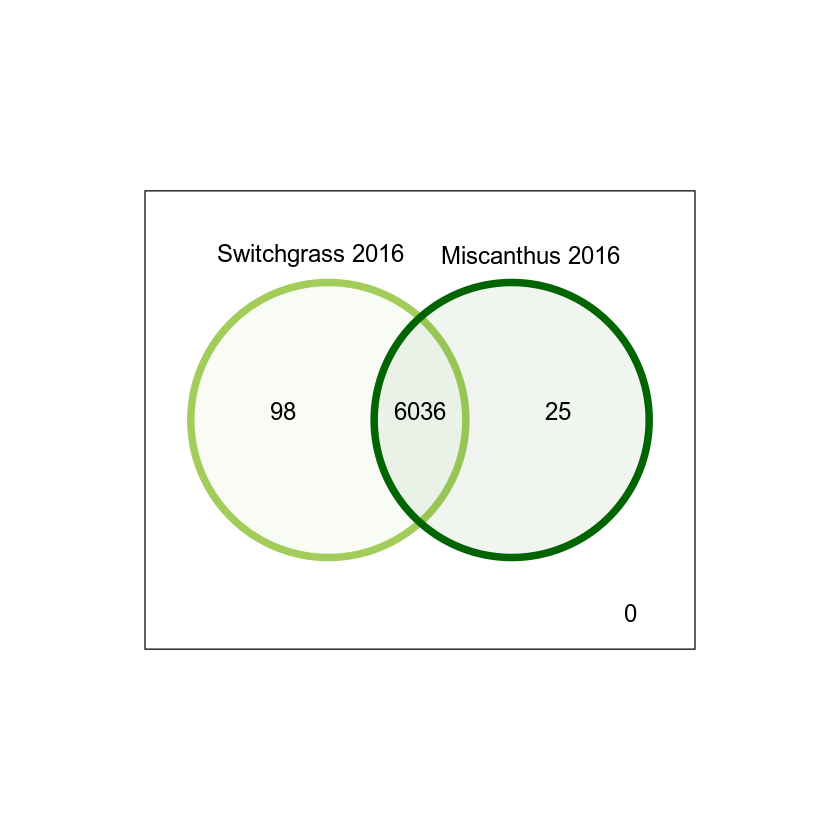

In [12]:
###########################
#' Venn diagram - Figure S7
###########################
#' Subsetting the data to the crop and year
otu_rare=otu_rare[rowSums(otu_rare)>0,]
map_16S = map_genes
misc_otu <- otu_rare[,map_16S$plant=="miscanthus"]
swit16_otu <- otu_rare[,map_16S$plant=="switchgrass"]

# make presence absence list from soil and plant into 1 & 0
swit16_otu_venn <- 1*(rowSums(swit16_otu)>0)
misc16_otu_venn <- 1*(rowSums(misc_otu)>0)

#' plot Venn
venn_phyllo_data <- cbind(swit16_otu_venn, misc16_otu_venn)
colnames(venn_phyllo_data) <- c("Switchgrass 2016", "Miscanthus 2016")
venn_phyllo_data=venn_phyllo_data[rowSums(venn_phyllo_data)>0,]
v_phyllo=vennCounts(venn_phyllo_data)
v_phyllo_2=round(v_phyllo[,"Counts"]/sum(v_phyllo[,"Counts"]),2) #calculate percentage of each group
vennDiagram(v_phyllo, circle.col = c('darkolivegreen3','darkgreen'), lwd=6, cex=1.2, scale=F)

In [26]:
#############################
#Occupancy abundance analysis
#############################

#Core analysis V2
rel_otu_rare <- decostand(otu_rare, method="total", MARGIN=2)
selected_otus <- data.frame(otu = as.factor(row.names(rel_otu_rare)), rel_otu_rare) %>% gather(sequence_name, abun, -otu) %>% 
  left_join(map_16S[, c('sequence_name','rep','time_numeric', 'treatment' ,'source', 'plant', 'month', 'sampling_date', 
                        'carbon_per_nitrogen', 'nitrogen_percent', 'carbon_percent', 'year')], by = 'sequence_name') 

#Switch 2016 
source='switchgrass 2016'
map_file <- map_16S %>%
  filter(plant == 'switchgrass',
         source == 'phyllosphere',
         year == '2016')
input <- swit16_otu
weeks <- c(1:10)
result <- NULL

for(i in weeks) {
  if(i %in% unique(map_file$sampling_week)) {
    name_sample <- map_file$sequence_name[map_file$sampling_week == i]
    timed_matrix <- input[,colnames(input) %in% name_sample]
    timed_matrix <- timed_matrix[rowSums(timed_matrix)>0,]
    timed_matrix_PA <- 1*((timed_matrix>0)==1)
    timed_matrix_PA <- timed_matrix_PA[rowSums(timed_matrix_PA)>0,]
    Occ <- rowSums(timed_matrix_PA)/ncol(timed_matrix_PA)
    rel_abun <- decostand(timed_matrix_PA, method="total", MARGIN=2)
    Mean_rel_abund <- apply(rel_abun, 1, mean)
    df_o <- data.frame(otu=names(Occ), occ=Occ) 
    df_a <- data.frame(otu=names(Mean_rel_abund), abun=log10(Mean_rel_abund))
    table <- left_join(df_a, df_o, by='otu') %>% mutate(week = i, source = source)
    result <- rbind(result, table)
  }
  else {
  }
}

In [22]:
map_file$sampling_week

NULL

In [27]:
occ1 <- result[result$occ==1,]
tempCore <- as.character(unique(occ1$otu))

#Comulative Occ_Abund
#Switch 2016 
swit16_otu <- swit16_otu[rowSums(swit16_otu)>0,]

swit_otu_PA <- 1*((swit16_otu>0)==1)
swit_otu_PA <- swit_otu_PA[rowSums(swit_otu_PA)>0,]
Occ_swit <- rowSums(swit_otu_PA)/ncol(swit_otu_PA)
swit_otu_rel <- decostand(swit16_otu, method="total", MARGIN=2)
Mean_abund_swit <- apply(swit_otu_rel, 1, mean)

#Creating df for plotting with ggplot and adding color code for the shared and unique OTUs
com_abund_swit <- rowSums(swit_otu_rel)
color_swit_top <- com_abund_swit
color_swit_top[] <- 'black'

swit_df_occ <- data.frame(otu=names(Occ_swit), occ=Occ_swit) 
swit_df_abun <- data.frame(otu=names(Mean_abund_swit), abun=log10(Mean_abund_swit))
switc_col <- data.frame(otu=names(color_swit_top), col=color_swit_top)
swit_occ_abun <- left_join(swit_df_abun, swit_df_occ, by='otu')
swit_occ_abun <- left_join(swit_occ_abun, switc_col, by='otu')

swit_occ_abun$core='no'
swit_occ_abun$core[as.character(swit_occ_abun$otu) %in% tempCore]='yes'

In [19]:
#swit_occ_abun$core
occ1$otu

NULL

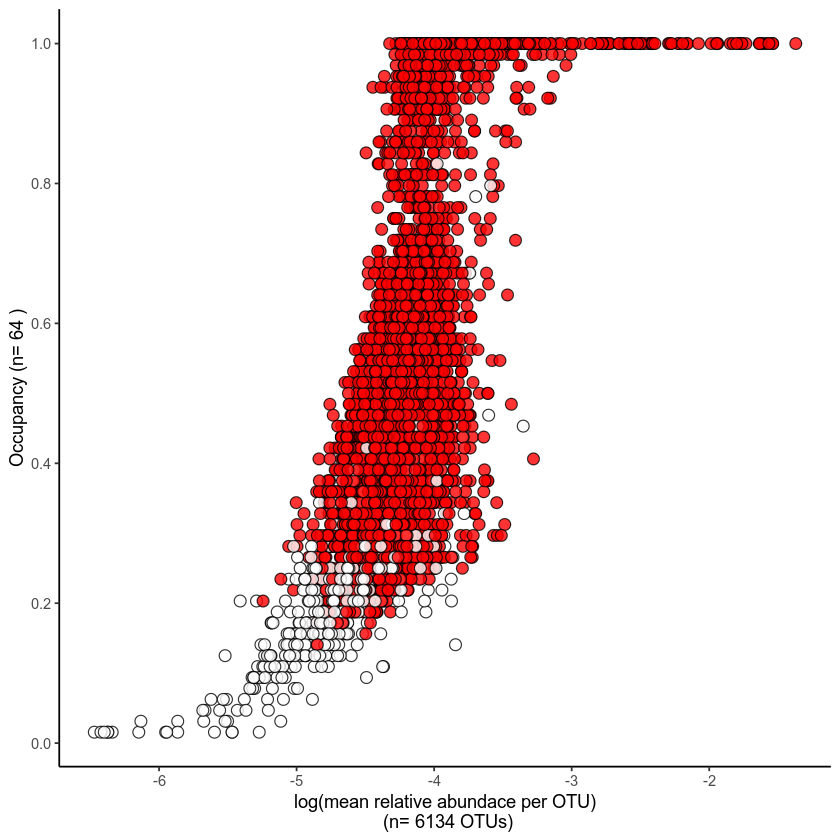

In [28]:
# swit_occ_abun$unique <- 'shared'
# # swit_occ_abun$unique[!(swit_occ_abun$otu %in% shared_season_switch)] <- 'Switchgrass 2016 (n=418)'
# swit_occ_abun$unique[(swit_occ_abun$otu %in% tempCore)] <- 'Switchgrass 2016 (n=51)'

sw16_occ_abun_plot <-ggplot(data=swit_occ_abun, aes(x=abun, y=occ, fill=core)) +
  theme_bw()+
  geom_point(size=3, pch=21, alpha=.8) +
  scale_fill_manual(breaks=unique, values=c('white','red')) +
  labs(x=paste('log(mean relative abundace per OTU)\n (n=',nrow(swit_df_abun),'OTUs)',sep=' '), y=paste('Occupancy (n=',ncol(swit_otu_PA),')', sep=' '), fill=NULL) +
  theme(legend.position = 'none',
        legend.background = element_rect(fill=alpha(0.1)),
        panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
  scale_y_continuous(breaks=seq(0,1,.2)) +
  guides(fill = guide_legend(override.aes = list(alpha = 1)))
sw16_occ_abun_plot

In [34]:
selected_otus_switch <- selected_otus[selected_otus$otu %in% tempCore,]

selected_otus_switch %>%
  filter(plant == 'switchgrass') %>%
  group_by(sampling_date,otu) %>%
  summarize(n=sum(abun>0)/length(abun),
                   all=length(abun),
                   rep_ab=mean(abun),
                   sd_rep=sd(abun)
  ) %>%
  filter(n>0) -> temp

In [33]:
head(temp)

sampling_date,n,all,rep_ab,sd_rep
<chr>,<dbl>,<int>,<dbl>,<dbl>
2016-05-09,0.2085433,44456,0.0001792760,0.002383079
2016-05-31,0.2018175,44456,0.0001795132,0.002217217
2016-06-20,0.2872728,44456,0.0001780734,0.002054958
2016-07-12,0.3178873,44456,0.0001783203,0.001822112
2016-08-01,0.6127182,44456,0.0001763510,0.001596082
2016-08-22,0.8476921,44456,0.0001707188,0.000607246


In [35]:
#df with stats for the whole dataset per OTU
selected_otus_switch %>%
  filter(source == 'phyllosphere' & plant == 'switchgrass' & year == 2016) %>%
  group_by(otu) %>%
  dplyr::summarise(
    all_ab=mean(abun),
    all_sd=sd(abun)
  ) -> temp2

In [36]:
#combining df and calculating the z-score
z_df <- left_join(temp, temp2)
z_df %>% arrange(otu) %>%
  mutate(
    z_score=(rep_ab-all_ab)/all_sd
  ) -> tmp3

Joining, by = "otu"


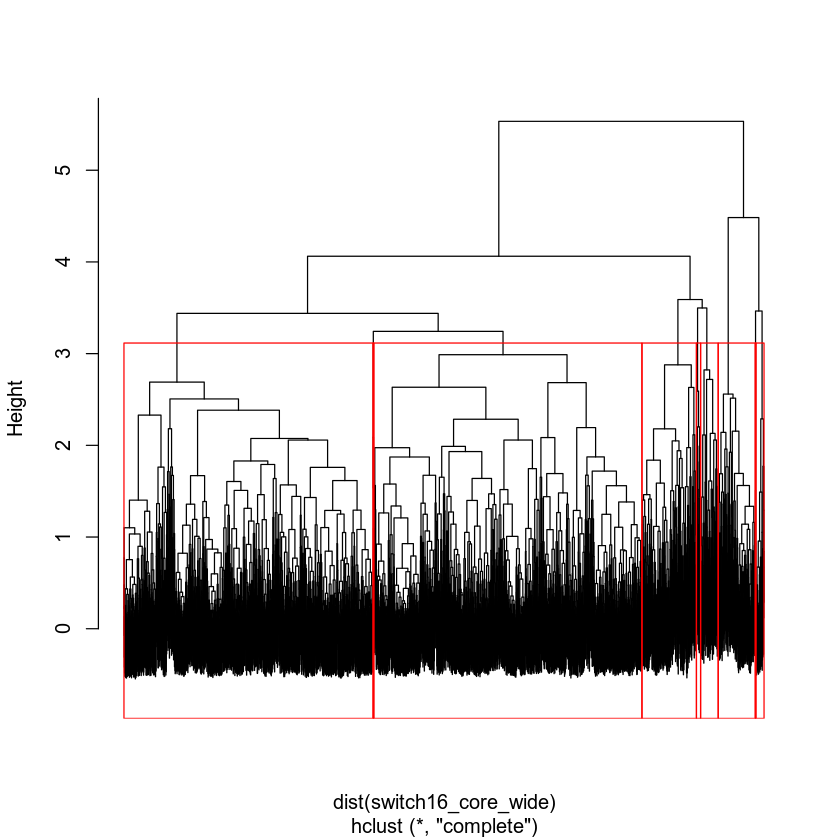

In [46]:
switch16_core <- tmp3[,c(1,2,9)]
switch16_core <- as.data.frame(switch16_core)
switch16_core_wide <- spread(switch16_core, key='sampling_date', value='z_score')
switch16_core_wide[is.na(switch16_core_wide)] <- 0
rownames(switch16_core_wide) <- switch16_core_wide$otu
switch16_core_wide$otu <-  NULL
set.seed(20)
clusters_switch16 <- hclust(dist(switch16_core_wide),'complete')
memb_sw16 <- cutree(clusters_switch16, k=8)
sw16_dend <- plot(clusters_switch16, main=NULL, labels = FALSE)
rect.hclust(clusters_switch16, k=9)

In [40]:
head(switch16_core)

sampling_date,otu,n,all,rep_ab,sd_rep,all_ab,all_sd,z_score
<chr>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-08-22,(-)-trans-carveol dehydrogenase,0.125,8,2.183514e-05,6.175911e-05,4.240826e-05,8.237587e-05,-0.2497469
2016-09-12,(-)-trans-carveol dehydrogenase,1.000,8,1.276290e-04,5.685305e-05,4.240826e-05,8.237587e-05,1.0345356
2016-10-03,(-)-trans-carveol dehydrogenase,1.000,8,1.898019e-04,1.006798e-04,4.240826e-05,8.237587e-05,1.7892820
2016-07-12,"(2E,6E)-farnesyl diphosphate synthase",0.125,8,5.856705e-06,1.656526e-05,6.282131e-05,8.155206e-05,-0.6985059
2016-08-01,"(2E,6E)-farnesyl diphosphate synthase",0.625,8,3.325499e-05,3.637533e-05,6.282131e-05,8.155206e-05,-0.3625452
2016-08-22,"(2E,6E)-farnesyl diphosphate synthase",0.875,8,1.151434e-04,6.658603e-05,6.282131e-05,8.155206e-05,0.6415790


Warning message:
“Column `otu` joining factor and character vector, coercing into character vector”

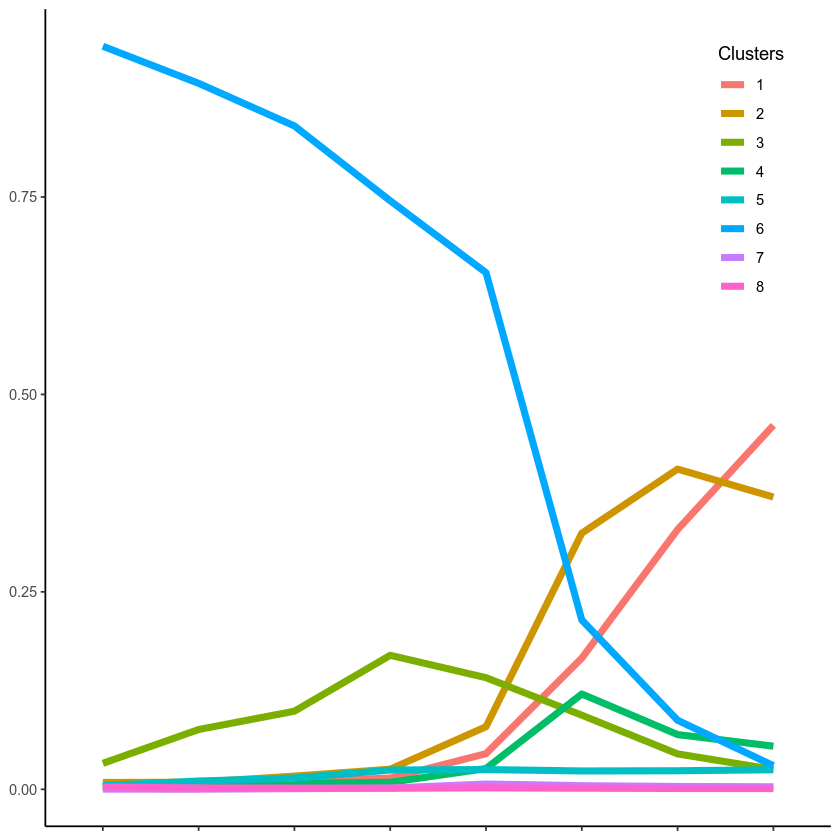

In [57]:
sw16_clusters <- data.frame(memb_sw16)
sw16_clusters$otu <-  rownames(sw16_clusters)
# sw16_clusters$stage <- 'mid'
# sw16_clusters$stage[sw16_clusters$memb_sw16==3] <- 'early'
# sw16_clusters$stage[sw16_clusters$memb_sw16==2] <- 'late'
# sw16_clusters$stage[sw16_clusters$memb_sw16==4] <- 'late'
# sw16_clusters$stage[sw16_clusters$memb_sw16==5] <- 'early'

sw_core_abundance <- data.frame(otu = as.factor(row.names(rel_otu_rare)), rel_otu_rare) %>% 
  gather(sequence_name, abun, -otu) %>%  
  left_join(map_16S[, c('sequence_name','source', 'plant', 'sampling_date', 'sampling_week','rep')], by = 'sequence_name') %>%
  filter(plant == 'switchgrass') %>%
  filter(otu %in% tempCore) %>%
  left_join(sw16_clusters, by='otu') %>%
  group_by(sampling_date) %>%
  mutate(sample_size = length(unique(sequence_name))) %>%
  group_by(sampling_week, sampling_date, memb_sw16) %>%
  summarize(n_relabun=sum(abun)/unique(sample_size)) %>%
  filter(!is.na(memb_sw16)) %>%
  ggplot(aes(x=factor(sampling_week), y=n_relabun, color=as.factor(memb_sw16), group=memb_sw16))+
  geom_line(size=2)+
  #scale_color_manual(values = c('red','blue','grey'))+
  theme_classic() + theme(strip.background = element_blank(),
                          legend.position = c(.9,.8),
                          axis.text.x =element_blank()) +
  labs(x=NULL, y=NULL, color='Clusters') 
sw_core_abundance

In [37]:
#TODO: When we have the higher functions of traits, we will use taxonmy as higher functional states set that to tax_filtered
sw_core_taxonomy <- data.frame(otu = as.factor(row.names(rel_otu_rare)), rel_otu_rare) %>% 
  gather(sequence_name, abun, -otu) %>%  
  left_join(map_16S[, c('sequence_name','source', 'plant', 'sampling_date', 'sampling_week','rep')], by = 'sequence_name') %>%
  filter(year == 2016, plant == 'switchgrass', source != 'soil') %>%
  filter(otu %in% tempCore) %>%
  left_join(sw16_clusters, by='otu') %>%
  left_join(tax_filtered, by='otu') %>%
  group_by(Class, sampling_week) %>%  #can replace 'Class' with a column name in the function hierarchy (eg pathway)
  summarise(n_count=sum(abun),
            n_sample=length(unique(sequence_name)),
            norm_ra=n_count/n_sample) %>%
  ggplot(aes(x=as.factor(sampling_week), y=norm_ra, color=Class, group=Class)) +
  geom_line(size=2) +
  theme_classic() + theme(strip.background = element_blank(), 
                          legend.position='none')+
  labs(x='Sampling week', y=NULL, color=NULL)

In [37]:
#TODO: change the things we did above to repeat the analysis for miscanthus
#Miscanthus 2016
source='miscanthus 2016'
map_file <- map_16S %>%
  filter(plant == 'miscanthus',
         source == 'phyllosphere',
         year == '2016')
input <- misc_otu
weeks <- c(1:10)
result <- NULL

for(i in weeks) {
  if(i %in% unique(map_file$sampling_week)) {
    name_sample <- map_file$sequence_name[map_file$sampling_week == i]
    timed_matrix <- input[,colnames(input) %in% name_sample]
    timed_matrix <- timed_matrix[rowSums(timed_matrix)>0,]
    timed_matrix_PA <- 1*((timed_matrix>0)==1)
    timed_matrix_PA <- timed_matrix_PA[rowSums(timed_matrix_PA)>0,]
    Occ <- rowSums(timed_matrix_PA)/ncol(timed_matrix_PA)
    rel_abun <- decostand(timed_matrix_PA, method="total", MARGIN=2)
    Mean_rel_abund <- apply(rel_abun, 1, mean)
    df_o <- data.frame(otu=names(Occ), occ=Occ) 
    df_a <- data.frame(otu=names(Mean_rel_abund), abun=log10(Mean_rel_abund))
    table <- left_join(df_a, df_o, by='otu') %>% mutate(week = i, source = source)
    result <- rbind(result, table)
  }
  else {
  }
}

length(unique(result$week))
occ1_m16 <- result[result$occ==1,]
tempCore_m16 <- as.character(unique(occ1_m16$otu))

misc_otu <- misc_otu[rowSums(misc_otu)>0,]
misc_otu_PA <- 1*((misc_otu>0)==1)
misc_otu_PA <- misc_otu_PA[rowSums(misc_otu)>0,]
Occ_misc <- rowSums(misc_otu_PA)/ncol(misc_otu_PA)
misc_otu <- misc_otu[rowSums(misc_otu)>0,]
misc_otu_rel <- decostand(misc_otu, method="total", MARGIN=2)
Mean_abund_misc <- apply(misc_otu_rel, 1, mean)

#Creating df for plotting with ggplot and adding color code for the shared and unique OTUs
com_abund_misc <- rowSums(misc_otu_rel)
color_misc_top <- com_abund_misc
color_misc_top[] <- 'black' 

misc_df_occ <- data.frame(otu=names(Occ_misc), occ=Occ_misc) 
misc_df_abun <- data.frame(otu=names(Mean_abund_misc), abun=log10(Mean_abund_misc))
misc_col <- data.frame(otu=names(color_misc_top), col=color_misc_top)
misc_occ_abun <- left_join(misc_df_abun, misc_df_occ, by='otu')
misc_occ_abun <- left_join(misc_occ_abun, misc_col, by='otu')

misc_occ_abun$unique <- 'shared'
misc_occ_abun$unique[!(misc_occ_abun$otu %in% shared)] <- 'Miscanthus 2016 (n=614)'
misc_occ_abun$unique[(misc_occ_abun$otu %in% tempCore_m16)] <- 'Miscanthus 2017 (n=44)'

mi_occ_abun_plot <- ggplot(data=misc_occ_abun, aes(x=abun, y=occ, fill=unique)) +
  theme_bw()+
  geom_point(size=3, pch=21, alpha=.8) +
  scale_fill_manual(breaks=unique, values=c('grey', 'darkgreen', 'white')) +
  labs(x=paste('log(mean relative abundace per OTU)\n (n=',nrow(misc_occ_abun),' OTUs)',sep=''), y=paste('Occupancy (n=',ncol(misc_otu_PA),')', sep=''), fill=NULL) +
  theme(legend.position = 'none',
        legend.background = element_rect(fill=alpha(0.1)),
        panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +
  scale_y_continuous(breaks=seq(0,1,.2)) +
  guides(fill = guide_legend(override.aes = list(alpha = 1)))

selected_otus_misc <- selected_otus[selected_otus$otu %in% tempCore_m16,]

selected_otus_misc %>%
  filter(source == 'phyllosphere' & plant == 'miscanthus' & year == 2016) %>%
  group_by(sampling_date, final_names, Class, Order, Family, Genus) %>%
  dplyr::summarise(n=sum(abun>0)/length(abun),
                   all=length(abun),
                   rep_ab=mean(abun),
                   sd_rep=sd(abun)
  ) %>%
  filter(n>0) -> temp

#df with stats for the whole dataset per OTU
selected_otus_misc %>%
  filter(source == 'phyllosphere' & plant == 'miscanthus' & year == 2016) %>%
  group_by(final_names, otu) %>%
  dplyr::summarise(
    all_ab=mean(abun),
    all_sd=sd(abun)
  ) -> temp2

#combining df and calculating the z-score
z_df <- left_join(temp, temp2)
z_df %>% arrange(otu) %>%
  mutate(
    z_score=(rep_ab-all_ab)/all_sd
  ) %>%
  arrange(Class, Family) -> tmp3

misc_core <- tmp3[,c(1,14,11)]
misc_core <- as.data.frame(misc_core)
misc_core_wide <- spread(misc_core, key='sampling_date', value='z_score')
misc_core_wide[is.na(misc_core_wide)] <- 0
rownames(misc_core_wide) <- misc_core_wide$otu
misc_core_wide$otu <-  NULL
set.seed(22)
clusters_misc <- hclust(dist(misc_core_wide),'complete')
memb_misc <- cutree(clusters_misc, k=8)
misc_dend <- plot(clusters_misc, main=NULL)
rect.hclust(clusters_misc, k=8)

setEPS()
postscript('~/Desktop/figureS8.eps', width=18, height=4, paper = 'special')
par(mfrow=c(1,3))
plot(clusters_misc, main=NULL)
rect.hclust(clusters_misc, k=8)
plot(clusters_switch16, main=NULL)
rect.hclust(clusters_switch16, k=5)
plot(clusters_switch17, main=NULL)
rect.hclust(clusters_switch17, k=7)
dev.off()
par(mfrow=c(1,1))

misc_clusters <- data.frame(memb_misc)
misc_clusters$otu <-  rownames(misc_clusters)
misc_clusters$stage <- 'mid'
misc_clusters$stage[misc_clusters$memb_misc==3] <- 'late'
misc_clusters$stage[misc_clusters$memb_misc==2] <- 'mid'
misc_clusters$stage[misc_clusters$memb_misc==4] <- 'mid'
misc_clusters$stage[misc_clusters$memb_misc==5] <- 'early'
misc_clusters$stage[misc_clusters$memb_misc==6] <- 'late'
misc_clusters$stage[misc_clusters$memb_misc==7] <- 'early'
misc_clusters$stage[misc_clusters$memb_misc==8] <- 'early'


misc_core_abundance <- data.frame(otu = as.factor(row.names(rel_otu_rare)), rel_otu_rare) %>% 
  gather(sequence_name, abun, -otu) %>%  
  left_join(map_16S[, c('sequence_name','source', 'plant', 'sampling_date', 'year', 'sampling_week','rep')], by = 'sequence_name') %>%
  filter(year == 2016, plant == 'miscanthus', source != 'soil') %>%
  filter(otu %in% tempCore_m16) %>%
  left_join(misc_clusters, by='otu') %>%
  group_by(sampling_date) %>%
  mutate(sample_size = length(unique(sequence_name))) %>%
  group_by(sampling_week, sampling_date, memb_misc, stage) %>%
  summarize(n_relabun=sum(abun)/unique(sample_size)) %>%
  filter(!is.na(memb_misc)) %>%
  ggplot(aes(x=as.factor(sampling_week), y=n_relabun, color=stage, group=memb_misc))+
  geom_line(size=2)+
  scale_color_manual(values = c('red','blue','grey'))+
  theme_classic() + theme(strip.background = element_blank(),
                          legend.position = 'none',
                          axis.text.x =element_blank()) +
  labs(x=NULL, y='Relative\n abundance') 

misc_core_taxonomy <- data.frame(otu = as.factor(row.names(rel_otu_rare)), rel_otu_rare) %>% 
  gather(sequence_name, abun, -otu) %>%  
  left_join(map_16S[, c('sequence_name','source', 'plant', 'sampling_date', 'year', 'sampling_week','rep')], by = 'sequence_name') %>%
  filter(year == 2016, plant == 'miscanthus', source != 'soil') %>%
  filter(otu %in% tempCore_m16) %>%
  left_join(misc_clusters, by='otu') %>%
  left_join(tax_filtered, by='otu') %>%
  group_by(Class, sampling_week) %>%
  summarise(n_count=sum(abun),
            n_sample=length(unique(sequence_name)),
            norm_ra=n_count/n_sample) %>%
  ggplot(aes(x=as.factor(sampling_week), y=norm_ra, color=Class, group=Class)) +
  geom_line(size=2) +
  theme_classic() + theme(strip.background = element_blank(), legend.position = 'none') +
  labs(x=NULL, y='Relative\n abundance', color=NULL)

In [60]:
dim(otu_rare)

[1] 6159  136

In [62]:
#Contribution of the core to community dissimilarity
#switch 2016
switch16full <- otu_rare[,map_16S$plant == 'switchgrass']
switch16full <- switch16full[rowSums(switch16full)>0,]
switch16core <- switch16full[rownames(switch16full) %in% tempCore,]

#Calculates bray-curtis distance
for(i in switch16full){
  week = c(1:8) 
  switch16_BC_full <- NULL
  for(i in week){
    samples = map_16S$sequence_name[map_16S$sampling_week== i]    #selecting the unique dates for pairwise calcualtions
    time_sub=switch16full[,colnames(switch16full) %in% samples]   #subsetting matrix to the selected dates
    x <- apply(combn(ncol(time_sub), 2), 2, function(x) sum(abs(time_sub[,x[1]]- time_sub[,x[2]]))/(sum(time_sub[, x[1]]) + sum(time_sub[, x[2]]))) 
    x_names <- apply(combn(ncol(time_sub), 2), 2, function(x) paste(colnames(time_sub)[x], collapse=' - '))
    df <- data.frame(x, x_names, i)
    switch16_BC_full <- rbind(switch16_BC_full,df)
  }
}

In [66]:
head(switch16core)

,G5R1_MAIN_01AUG2016_LD1,G5R1_MAIN_03OCT2016_LD1,G5R1_MAIN_09MAY2016_LD1,G5R1_MAIN_12JUL2016_LD1,G5R1_MAIN_12SEP2016_LD1,G5R1_MAIN_20JUN2016_LD1,G5R1_MAIN_22AUG2016_LD1,G5R1_MAIN_31MAY2016_LD1,G5R1_NF_01AUG2016_LD1,G5R1_NF_03OCT2016_LD1,⋯,G5R4_MAIN_22AUG2016_LD1,G5R4_MAIN_31MAY2016_LD1,G5R4_NF_01AUG2016_LD1,G5R4_NF_03OCT2016_LD1,G5R4_NF_09MAY2016_LD1,G5R4_NF_12JUL2016_LD1,G5R4_NF_12SEP2016_LD1,G5R4_NF_20JUN2016_LD1,G5R4_NF_22AUG2016_LD1,G5R4_NF_31MAY2016_LD1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(-)-trans-carveol dehydrogenase,0.0000000,18.000000,0.0000000,0.000000,5.000000,0.0000000,0.000000,0.0000000,0.0000000,20.000000,⋯,0.0000000,0.0000000,0.0000000,3.000000,0.0000000,0.000000,6.000000,0.000000,0.0000000,0.000000
"(2E,6E)-farnesyl diphosphate synthase",0.3333333,18.333333,0.0000000,0.000000,10.333333,0.0000000,2.666667,0.0000000,0.6666667,8.333333,⋯,1.3333333,0.0000000,1.0000000,11.333333,0.0000000,0.000000,3.666667,0.000000,1.0000000,0.000000
(2R)-3-sulfolactate dehydrogenase (NADP(+)),0.0000000,5.333333,0.0000000,0.000000,3.666667,0.0000000,1.666667,0.0000000,0.6666667,4.666667,⋯,0.3333333,0.0000000,0.3333333,5.000000,0.0000000,0.000000,4.000000,0.000000,0.6666667,0.000000
(2R)-sulfolactate sulfo-lyase subunit beta,0.5000000,22.250000,0.0000000,0.000000,15.250000,0.0000000,5.500000,0.0000000,1.7500000,21.000000,⋯,8.2500000,0.0000000,1.0000000,34.000000,0.0000000,0.000000,12.250000,0.000000,2.7500000,0.000000
(2S)-methylsuccinyl-CoA dehydrogenase,0.0000000,6.000000,0.0000000,0.000000,8.307692,0.0000000,2.769231,0.0000000,0.4615385,5.692308,⋯,2.0000000,0.0000000,0.4615385,9.076923,0.0000000,0.000000,4.307692,0.000000,0.3076923,0.000000
"(2Z,6E)-farnesyl diphosphate synthase",0.6666667,6.888889,0.2222222,1.111111,4.666667,0.6666667,1.555556,0.4444444,1.5555556,1.111111,⋯,1.7777778,0.8888889,1.7777778,2.444444,0.2222222,1.777778,2.666667,1.111111,1.1111111,1.111111


In [67]:
for(i in switch16core){
  week = c(1:8) 
  switch16_BC_core <- NULL
  for(i in week){
    samples = map_16S$sequence_name[map_16S$sampling_week== i]    #selecting the unique dates for pairwise calcualtions
    time_sub=switch16core[,colnames(switch16core) %in% samples]   #subsetting matrix to the selected dates
    x <- apply(combn(ncol(time_sub), 2), 2, function(x) sum(abs(time_sub[,x[1]]- time_sub[,x[2]]))/(sum(time_sub[, x[1]]) + sum(time_sub[, x[2]]))) 
    x_names <- apply(combn(ncol(time_sub), 2), 2, function(x) paste(colnames(time_sub)[x], collapse=' - '))
    df <- data.frame(x, x_names, i)
    switch16_BC_core <- rbind(switch16_BC_core,df)
  }
}

[1] 0.9639732

Warning message:
“Removed 645 rows containing missing values (geom_violin).”

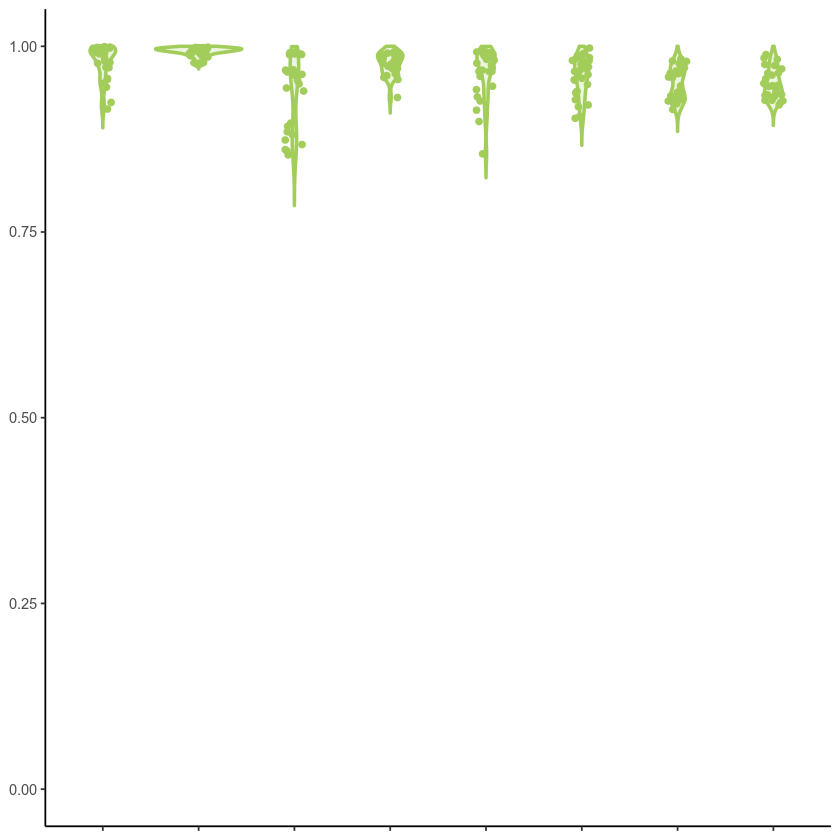

In [68]:
diffBC_switch16 <- left_join(switch16_BC_full,switch16_BC_core, by=c('x_names', 'i'))
diffBC_switch16$diff_BC <- diffBC_switch16$x.y/diffBC_switch16$x.x
mean(diffBC_switch16$diff_BC)

sw_BC_new <- ggplot(diffBC_switch16, aes(x=factor(i), y=diff_BC)) +
  geom_violin(trim=FALSE,cex=1, color='darkolivegreen3',fill='darkolivegreen3', alpha=.2)+
  geom_jitter(width=0.1, color='darkolivegreen3')+
  ylim(0,1)+
  theme_bw()+
  labs(x=NULL, y=NULL)+
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
        panel.background = element_blank(), axis.line = element_line(colour = "black"), 
        axis.text.x = element_blank(), panel.border = element_blank())
sw_BC_new

In [37]:
#TODO: Follow same patterns as above with rowsums
#misc 2016
misc16full <- otu_rare[,map_16S$plant == 'miscanthus' & map_16S$year == 2016 & map_16S$source == 'phyllosphere']
misc16full <- misc16full[rowSums(misc16full)>0,]
misc16core <- misc16full[rownames(misc16full) %in% tempCore_m16,]
#unique(map_16S$sampling_week[map_16S$plant == 'miscanthus' & map_16S$year == 2016 & map_16S$source == 'phyllosphere'])

for(i in misc16full){
  week = c(1:9) 
  misc16_BC_full <- NULL
  for(i in week){
    samples = map_16S$sequence_name[map_16S$sampling_week== i]    #selecting the unique dates for pairwise calcualtions
    time_sub=misc16full[,colnames(misc16full) %in% samples]   #subsetting matrix to the selected dates
    x <- apply(combn(ncol(time_sub), 2), 2, function(x) sum(abs(time_sub[,x[1]]- time_sub[,x[2]]))/2000) 
    x_names <- apply(combn(ncol(time_sub), 2), 2, function(x) paste(colnames(time_sub)[x], collapse=' - '))
    df <- data.frame(x, x_names, i)
    misc16_BC_full <- rbind(misc16_BC_full,df)
  }
}

for(i in misc16core){
  week = c(3:9) 
  misc16_BC_core <- NULL
  for(i in week){
    samples = map_16S$sequence_name[map_16S$sampling_week== i]    #selecting the unique dates for pairwise calcualtions
    time_sub=misc16core[,colnames(misc16core) %in% samples]   #subsetting matrix to the selected dates
    x <- apply(combn(ncol(time_sub), 2), 2, function(x) sum(abs(time_sub[,x[1]]- time_sub[,x[2]]))/2000) 
    x_names <- apply(combn(ncol(time_sub), 2), 2, function(x) paste(colnames(time_sub)[x], collapse=' - '))
    df <- data.frame(x, x_names, i)
    misc16_BC_core <- rbind(misc16_BC_core,df)
  }
}

diffBC_misc16 <- left_join(misc16_BC_full,misc16_BC_core, by=c('x_names', 'i'))
diffBC_misc16$diff_BC <- diffBC_misc16$x.y/diffBC_misc16$x.x
mean(diffBC_misc16$diff_BC)
misc_BC_new <- ggplot(diffBC_misc16, aes(x=factor(i), y=diff_BC)) +
  geom_violin(trim=FALSE, cex=1, color='darkgreen', fill='darkgreen', 
              alpha=.2) +
  geom_jitter(width=0.1, color='darkgreen') +
  ylim(0,1) +
  expand_limits(x =factor(seq(1,9, by=1))) +
  theme_bw() +
  labs(x=NULL, y='Fraction of beta diversity\nwithin the time points') +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
        panel.background = element_blank(), axis.line = element_line(colour = "black"), 
        axis.text.x = element_blank(), panel.border = element_blank())

# Heatmap

In [37]:
#Figure 4
grid.arrange(ggarrange(mi_occ_abun_plot,sw16_occ_abun_plot, 
                       misc_core_abundance,sw_core_abundance, 
                       misc_BC_new, sw_BC_new, 
                       misc_core_taxonomy,sw_core_taxonomy, 
                       nrow=4))

############################
#Heatmap - Figure S4
############################
#' Preparing the data for plotting 
plant_otu <- otu_rare[,map_16S$source=="phyllosphere"]
plant_otu <- plant_otu[rowSums(plant_otu)>0,]
soil_otu <- otu_rare[,map_16S$source=="soil"] 
soil_otu <- soil_otu[rowSums(soil_otu)>0,]

soil_relabun <- decostand(soil_otu,method="total", MARGIN=2)
plant_relabun <- decostand(plant_otu,method="total", MARGIN=2)

soilOTU_df <- data.frame(otu=rownames(soil_relabun), soil_relabun) %>% 
  gather(sequence_name, relabun, -otu) %>%
  mutate(source='soil')
soilOTUsub_df <- soilOTU_df[soilOTU_df$otu %in% rownames(plant_relabun),]

leafOTU_df <- data.frame(otu=rownames(plant_relabun), plant_relabun) %>% 
  gather(sequence_name, relabun, -otu) %>%
  mutate(source='phyllosphere')

OTU_relabun_notime <- rbind(soilOTUsub_df, leafOTU_df) %>%
  left_join(map_16S[,c('sequence_name', 'sampling_date', 'year', 'plant')], by='sequence_name') %>%
  group_by(source, otu, year, plant) %>%
  summarise(rel_abun=sum(relabun)/length(unique(sequence_name)))
OTU_relabun_notime$memb <- 'other'
OTU_relabun_notime$memb[OTU_relabun_notime$otu %in% unique(core_list)] <- 'core'

#' Calculating soil OTU ranks
misc_soil_otu <- otu_rare[,map_16S$plant=="miscanthus" & (map_16S$source=='soil')]
swit16_soil_otu <- otu_rare[,map_16S$plant=="switchgrass" & (map_16S$source=='soil') & (map_16S$year==2016)]
swit17_soil_otu <- otu_rare[,map_16S$plant=="switchgrass" & (map_16S$source=='soil') & (map_16S$year==2017)]
misc_soil_rank=sort(rowSums(misc_soil_otu)/sum(rowSums(misc_soil_otu)), decreasing=TRUE)
s16_soil_rank=sort(rowSums(swit16_soil_otu)/sum(rowSums(swit16_soil_otu)), decreasing=TRUE)
s17_soil_rank=sort(rowSums(swit17_soil_otu)/sum(rowSums(swit17_soil_otu)), decreasing=TRUE)

#Miscanthus
misc_soil_phyllo_df <- data.frame(rel_abun=misc_soil_rank, otu = names(misc_soil_rank))
misc_soil_phyllo_df$source <- 'soil'
misc_soil_phyllo_df$source[misc_soil_phyllo_df$otu %in% rownames(mis)] <- 'phyllo'
misc_soil_phyllo_df <- left_join(misc_soil_phyllo_df, OTU_relabun_notime[OTU_relabun_notime$source=='phyllosphere' & OTU_relabun_notime$plant=='miscanthus',], by='otu')
misc_soil_phyllo_df[is.na(misc_soil_phyllo_df)] <- 0
misc_soil_phyllo_df$otu <- factor(misc_soil_phyllo_df$otu, levels=misc_soil_phyllo_df$otu)
misc_soil_phyllo_df <- misc_soil_phyllo_df[misc_soil_phyllo_df$otu %in% rownames(mis),]

#Switchgrass 2016
s16_soil_phyllo_df <- data.frame(rel_abun=s16_soil_rank, otu = names(s16_soil_rank))
s16_soil_phyllo_df$source <- 'soil'
s16_soil_phyllo_df$source[s16_soil_phyllo_df$otu %in% rownames(sw)] <- 'phyllo'
s16_soil_phyllo_df <- left_join(s16_soil_phyllo_df, OTU_relabun_notime[OTU_relabun_notime$source=='phyllosphere',], by='otu')
s16_soil_phyllo_df[is.na(s16_soil_phyllo_df)] <- 0
s16_soil_phyllo_df <- s16_soil_phyllo_df[s16_soil_phyllo_df$otu %in% rownames(sw),]

#Switchgrass 2017
s17_soil_phyllo_df <- data.frame(rel_abun=s17_soil_rank, otu = names(s17_soil_rank))
s17_soil_phyllo_df$source <- 'soil'
s17_soil_phyllo_df$source[s17_soil_phyllo_df$otu %in% rownames(sw17)] <- 'phyllo'
s17_soil_phyllo_df <- left_join(s17_soil_phyllo_df, OTU_relabun_notime[OTU_relabun_notime$source=='phyllosphere' & OTU_relabun_notime$year == 2017,], by='otu') %>% arrange(desc(rel_abun.x))
s17_soil_phyllo_df[is.na(s17_soil_phyllo_df)] <- 0
s17_soil_phyllo_df <- s17_soil_phyllo_df[s17_soil_phyllo_df$otu %in% rownames(sw17),]

#' Creating abundance matrix for the heatmap
OTU_relabun <- rbind(soilOTUsub_df, leafOTU_df) %>%
  left_join(map_16S[,c('sequence_name', 'sampling_date', 'year', 'plant')], by='sequence_name') %>%
  group_by(source, otu, sampling_date,year, plant) %>%
  summarise(rel_abun=sum(relabun)/length(unique(sequence_name)))

OTU_relabun_leaf_s17<- OTU_relabun[OTU_relabun$source == 'phyllosphere' & OTU_relabun$plant == 'switchgrass' & OTU_relabun$year == '2017',]
rel_abun_matrix_sw17<- acast(OTU_relabun_leaf_s17[as.character(OTU_relabun_leaf_s17$otu) %in% s17_soil_phyllo_df$otu,], otu~sampling_date, value.var="rel_abun")
rel_abun_matrix_sw17 <- rel_abun_matrix_sw17[match(s17_soil_phyllo_df$otu,rownames(rel_abun_matrix_sw17)), ]
rel_abun_matrix_sw17 <- na.omit(rel_abun_matrix_sw17)
data_subset_s17 <- t(apply(rel_abun_matrix_sw17[rowSums(rel_abun_matrix_sw17)>0,], 1, cal_z_score))
my_sample_row <- data.frame(membership = rep('other', length(rownames(rel_abun_matrix_sw17))))
my_sample_row$membership <- as.character(my_sample_row$membership)
my_sample_row$membership[rownames(rel_abun_matrix_sw17) %in% unique(sw17_clusters$otu)] <- 'core'
rownames(my_sample_row) <- rownames(rel_abun_matrix_sw17)
s17_heatmap <- pheatmap(data_subset_s17[1:50,], annotation_row = my_sample_row, cluster_rows = F, cluster_cols = F)

OTU_relabun_leaf_s16<- OTU_relabun[OTU_relabun$source == 'phyllosphere' & OTU_relabun$plant == 'switchgrass' & OTU_relabun$year == '2016',]
s16_soil_phyllo_df <- s16_soil_phyllo_df[s16_soil_phyllo_df$plant=='switchgrass' & s16_soil_phyllo_df$year==2016,]
rel_abun_matrix_sw<- acast(OTU_relabun_leaf_s16[OTU_relabun_leaf_s16$otu %in% s16_soil_phyllo_df$otu,], otu~sampling_date, value.var="rel_abun")
rel_abun_matrix_sw <- rel_abun_matrix_sw[match(s16_soil_phyllo_df$otu, rownames(rel_abun_matrix_sw)), ]
rel_abun_matrix_sw <- na.omit(rel_abun_matrix_sw)
data_subset_s16 <- t(apply(rel_abun_matrix_sw[rowSums(rel_abun_matrix_sw)>0,], 1, cal_z_score))
my_sample_row <- data.frame(membership = rep('other', length(rownames(data_subset_s16))))
my_sample_row$membership <- as.character(my_sample_row$membership)
my_sample_row$membership[rownames(data_subset_s16) %in% unique(sw16_clusters$otu)] <- 'core'
rownames(my_sample_row) <- rownames(data_subset_s16)
s16_heatmap <- pheatmap(data_subset_s16[1:50,], cluster_rows = F, cluster_cols = F,  annotation_row = my_sample_row)

OTU_relabun_leaf_misc<- OTU_relabun[OTU_relabun$source == 'phyllosphere' & OTU_relabun$plant == 'miscanthus',]
rel_abun_matrix_misc<- acast(OTU_relabun_leaf_misc[OTU_relabun_leaf_misc$otu %in% misc_soil_phyllo_df$otu,], otu~sampling_date, value.var="rel_abun")
rel_abun_matrix_misc <- rel_abun_matrix_misc[match(misc_soil_phyllo_df$otu, rownames(rel_abun_matrix_misc)), ]
rel_abun_matrix_misc <- na.omit(rel_abun_matrix_misc)
data_subset_misc <- t(apply(rel_abun_matrix_misc[rowSums(rel_abun_matrix_misc)>0,], 1, cal_z_score))
my_sample_row <- data.frame(membership = rep('other', length(rownames(data_subset_misc))))
my_sample_row$membership <- as.character(my_sample_row$membership)
my_sample_row$membership[rownames(data_subset_misc) %in% unique(misc_clusters$otu)] <- 'core'
rownames(my_sample_row) <- rownames(data_subset_misc)
misc_heatmap <- pheatmap(data_subset_misc[1:50,], cluster_rows = F, cluster_cols = F, annotation_row = my_sample_row)

save_pheatmap_pdf(s17_heatmap, "~/Desktop/figure/figureS4c.pdf")

###############################################################
#Figure 5 - Dynamics of the OTUs classified as Alpha and Gamma proteobacteria
###############################################################
(proteo_plot <- data.frame(otu = as.factor(row.names(otu_rare)), otu_rare) %>% gather(sequence_name, abun, -otu) %>%
   left_join(map_16S[, c('sequence_name','rep','treatment' ,'source', 'plant', 'sampling_date', 'year','sampling_week'
   )], by = 'sequence_name') %>%
   left_join(tax_filtered, by='otu') %>%
   filter(grepl('Alphaproteobacteria|Betaproteobacteria|Deltaproteobacteria|Gammaproteobacteria', Class)) %>%
   filter(source == 'phyllosphere') %>%
   mutate(plant = factor(plant, levels = c('switchgrass', 'miscanthus'))) %>%
   mutate(class=if_else(Class=='Alphaproteobacteria','c:Alphaproteobacteria', Class)) %>%
   mutate(class=if_else(class=='Betaproteobacteria','c:Betaproteobacteria', class)) %>%
   mutate(class=if_else(class=='Gammaproteobacteria','c:Gammaproteobacteria', class)) %>%
   mutate(class=if_else(class=='Deltaproteobacteria','c:Deltaproteobacteria', class)) %>%
   group_by(plant, class, year,sampling_week) %>%
   summarise(n=sum(abun),
             n_reps=length(unique(sequence_name))) %>%
   group_by(plant, year,sampling_week) %>%
   mutate(total_reads=sum(n),
          rel_abun=n/total_reads) %>%
   ggplot(aes(x=as.factor(sampling_week), y=rel_abun, fill=class)) +
   geom_bar(color='black', stat = 'identity') +
   theme_classic() +
   facet_grid(~factor(plant, levels=c("miscanthus","switchgrass","switchgrass"), labels=c("miscanthus","switchgrass","switchgrass"))+year) +
   labs(x='Sampling week', y='Normalized relative\n abundance')+
   theme(axis.text.x = element_text(size=8),
         legend.position = 'bottom',
         legend.text=element_text(size=8),
         legend.key.size = unit(.3, "cm")) +
   guides(fill = guide_legend(ncol = 4, title=NULL)))

(snippet_otu <- selected_otus %>% 
    filter(otu %in% c('OTU4','OTU2', 'OTU4223'),
           source=='phyllosphere') %>%
    mutate(members=if_else(year==2016 & plant =='miscanthus', 'mi', 'sw16'),
           members=if_else(year==2017 & plant =='switchgrass', 'sw17', members)) %>%
    left_join(map_16S[,c('sequence_name','sampling_week')], by = 'sequence_name') %>%
    ggplot(aes(x = as.factor(sampling_week), y = abun, color = plant, fill = plant, group=members)) + 
    geom_point() +
    stat_smooth(method = "loess") +
    scale_color_manual(values=c('darkgreen','darkolivegreen3')) +
    scale_fill_manual(values=c('darkgreen','darkolivegreen3')) +
    labs(x="Sampling times", y= "Relative abundance") +
    facet_wrap(year ~ as.factor(Class)+final_names, scale = 'free_y', ncol=3) +
    theme_classic() + theme(strip.background = element_blank(),
                            axis.text.x = element_text(size=8),
                            legend.position = 'none',
                            strip.text.x = element_blank()))

setEPS()
# postscript('~/Desktop/figure/Figure5.eps', width = 6,height = 7, paper = 'special')
grid.draw(ggarrange(proteo_plot,
                    snippet_otu,
                    heights = 1:2.5))
dev.off()
### End Nejc Analysis

Warning message:
“non-unique values when setting 'row.names': ‘(-)-trans-carveol dehydrogenase’, ‘(2E,6E)-farnesyl diphosphate synthase’, ‘(2R)-3-sulfolactate dehydrogenase (NADP(+))’, ‘(2R)-sulfolactate sulfo-lyase subunit beta’, ‘(2S)-methylsuccinyl-CoA dehydrogenase’, ‘(2Z,6E)-farnesyl diphosphate synthase’, ‘(3S)-malyl-CoA thioesterase’, ‘(6-4) photolyase’, ‘(R)-2-hydroxyisocaproyl-CoA dehydratase alpha subunit’, ‘(R)-benzylsuccinyl-CoA dehydrogenase’, ‘(R)-citramalyl-CoA lyase’, ‘(R)-phenoxypropionate/alpha-ketoglutarate- dioxygenase’, ‘(R)-phenyllactyl-CoA dehydratase alpha subunit’, ‘(R)-specific enoyl-CoA hydratase’, ‘(R)-stereoselective amidase’, ‘(S)-1-Phenylethanol dehydrogenase’, ‘(S)-2-haloacid dehalogenase’, ‘(S)-2-haloacid dehalogenase 4A’, ‘(S)-mandelate dehydrogenase’, ‘(S)-sulfolactate dehydrogenase’, ‘(S)-ureidoglycine aminohydrolase’, ‘(S)-ureidoglycine--glyoxylate transaminase’, ‘[LysW]-aminoadipate semialdehyde transaminase’, ‘1-(5-phosphoribosyl)-5-[(5- phosphori

ERROR: Error in `.rowNamesDF<-`(x, value = value): duplicate 'row.names' are not allowed
